In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [4]:
# file result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [7]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y, chroms, coords, strands = [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2]).reshape(1, L, 6)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords), np.array(strands))

X, y, chroms, coords, strands = encode(known, phastcons, phylop)

coords = coords[chroms == 'chr1']
strands = strands[chroms == 'chr1']
print np.sum(y)
print X.shape

56808.0
(37110, 70, 6)


In [8]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

4306 7093 25711
(25711, 70, 6) (7093, 70, 6) (4306, 70, 6)
(25711, 70) (7093, 70) (4306, 70)


# Baseline models

In [12]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

# Conservation Meta

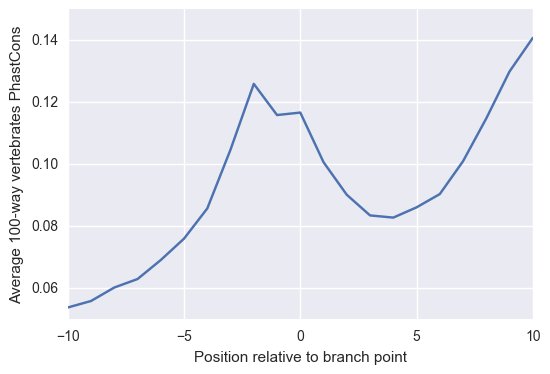

In [9]:
K = 10
counts = np.zeros((2*K+1,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1
plt.plot(range(-K, K+1), counts / total)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhastCons')
plt.show()

# Dist Model

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    22.    25.    37.    41.    39.    47.    41.    47.    61.    77.
    82.    81.    92.    93.   140.   146.   185.   212.   230.   273.
   299.   386.   434.   497.   620.   735.   877.  1053.  1255.  1486.
  1770.  2073.  2261.  2496.  2712.  2872.  2790.  2860.  2567.  2140.
  1676.  1191.   775.   401.   258.   160.    96.    94.    71.    42.
    30.    24.    28.    30.    21.     0.     0.     0.     0.     0.]


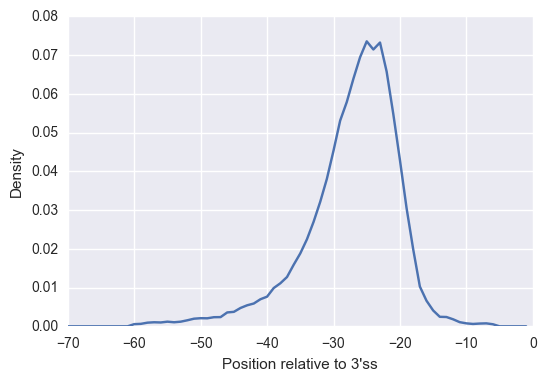

In [13]:
counts = np.zeros((L,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        counts[bp] += 1
        total += 1
print counts
dists = counts / float(total)
plt.plot(range(-70, 0), dists)
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.show()

In [14]:
def dist_pred(X, dists):
    return np.vstack([dists.T] * X.shape[0])

print matching(dist_pred(X_test, dists), y_test)
print matching(dist_pred(X_train, dists), y_train)

(433, 4306)
(2872, 25711)


# PWM model

In [15]:
K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm = counts / total

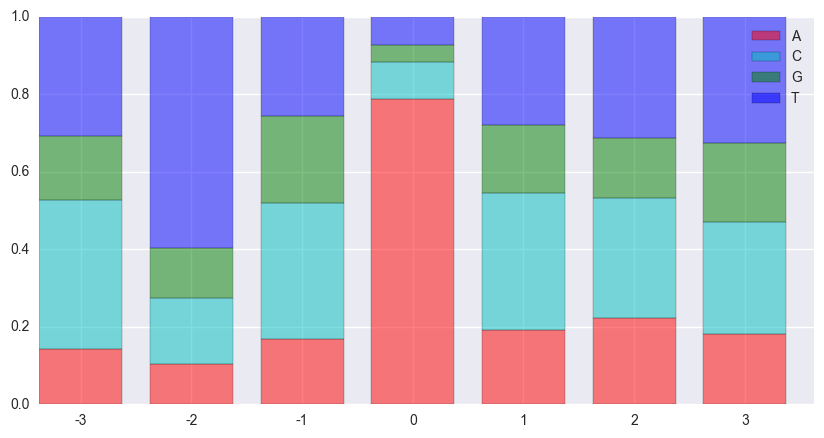

In [16]:
def pwm_logo(pwm, title = ''):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()
pwm_logo(pwm)

In [17]:
def pwm_pred(X, pwm):
    scores = []
    for seq in X:
        s = [0] * K
        for i in range(seq.shape[0] - K*2):
            s += [np.sum(seq[i:i+2*K+1, :4] * pwm)]
        s += [0] * K
        scores += [np.array(s)]
    return np.vstack(scores)

print matching(pwm_pred(X_test, pwm), y_test)
print matching(pwm_pred(X_train, pwm), y_train)

(1350, 4306)
(8539, 25711)


# Load model

In [34]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

In [44]:
train_preds = model.predict(X_train[:, :, :4]).reshape(-1, 70)
valid_preds = model.predict(X_valid[:, :, :4]).reshape(-1, 70)
test_preds = model.predict(X_test[:, :, :4]).reshape(-1, 70)

# Model Performance

# Compare to branchpointer

Do separatly becuase I can't get branchpointer to predict
scores for a subset of of our test set.

In [73]:
# All for chrom1
pos  = []
for line in open('../anno/branchpointer.pos.tsv'):
    pos += map(int, line.strip().split())
scores = []
for line in open('../anno/branchpointer.score.tsv'):
    scores += map(float, line.strip().split())
bptr = {p:score for p, score in zip(pos, scores)}
print len(bptr)

112451


In [74]:
bptr_preds = np.zeros((len(coords), 27))
for i, (three, strand) in enumerate(zip(coords, strands)):
    region = (range(three-44, three - 17)
              if strand == '+' else
              range(three + 45, three + 18, -1))
    #if strand == '+':continue
    for j, pos in enumerate(region):
        bptr_preds[i, j] = bptr[pos] if pos in bptr else 0

In [75]:
lstm_preds = test_preds[:, 25:25+27]

In [76]:
idx = np.max(bptr_preds, axis = 1) > 0

lstm_preds = lstm_preds[idx]
y_filt     = y_test[idx][:, 25:25+27]
bptr_preds = bptr_preds[idx]

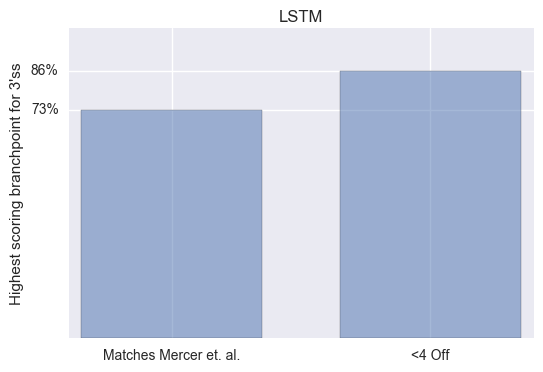

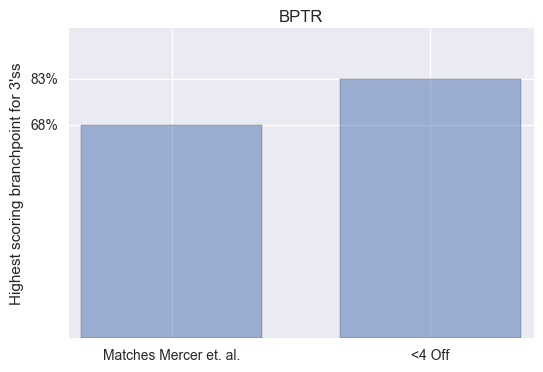

(2889, 619, 4197)

In [92]:
def shifted_matching(preds, true, title):
    E, B = 4, 4
    total, match, shifted = 0, 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        elif any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-E, np.argmax(p)+B+1)):
            shifted += 1
        total += 1
    heights = [match / float(total), (match+shifted) / float(total)]
    index = [0, .5]
    plt.bar(index, heights, .35, align = 'center', alpha = 0.5)
    plt.ylim(0, 1)
    plt.xticks(index, ['Matches Mercer et. al.', '<4 Off'])
    plt.yticks(heights, map(lambda x: "{}%".format(int(x * 100)), heights))
    plt.ylabel("Highest scoring branchpoint for 3'ss")
    plt.title(title)
    plt.show()
    return match, shifted, total

shifted_matching(lstm_preds, y_filt, 'LSTM')
shifted_matching(bptr_preds, y_filt, 'BPTR')

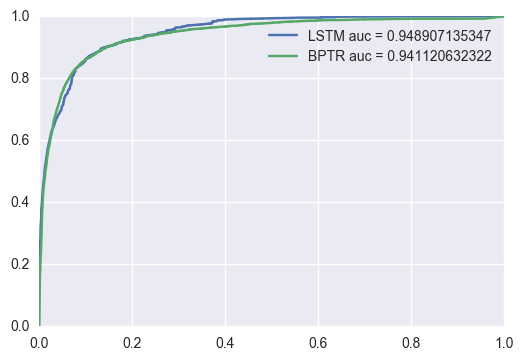

In [50]:
y_filt = y_filt.flatten()
lstm_preds = lstm_preds.flatten()
bptr_preds = bptr_preds.flatten()
fpr, tpr, thresholds = metrics.roc_curve(y_filt, lstm_preds, pos_label=1)
auc = metrics.roc_auc_score(y_filt, lstm_preds)
plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))

fpr, tpr, thresholds = metrics.roc_curve(y_filt, bptr_preds, pos_label=1)
auc = metrics.roc_auc_score(y_filt, bptr_preds)
plt.plot(fpr, tpr, label = "BPTR auc = {}".format(auc))
plt.legend()
plt.show()

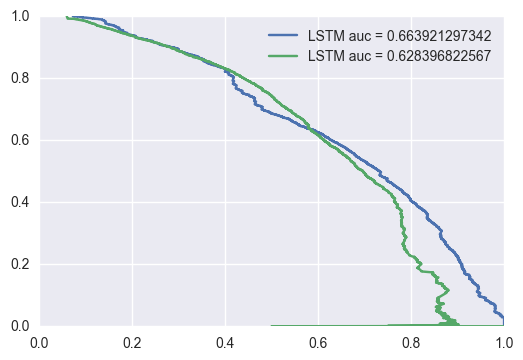

In [51]:
fpr, tpr, thresholds = metrics.precision_recall_curve(y_filt, lstm_preds, pos_label=1)
auc = metrics.average_precision_score(y_filt, lstm_preds)
plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))

fpr, tpr, thresholds = metrics.precision_recall_curve(y_filt, bptr_preds, pos_label=1)
auc = metrics.average_precision_score(y_filt, bptr_preds)
plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
plt.legend()
plt.show()

## auROC on train, valid, test

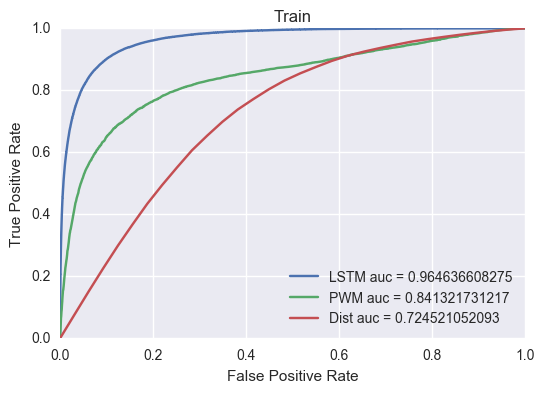

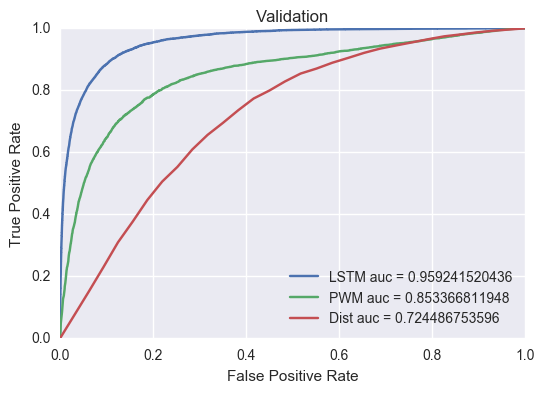

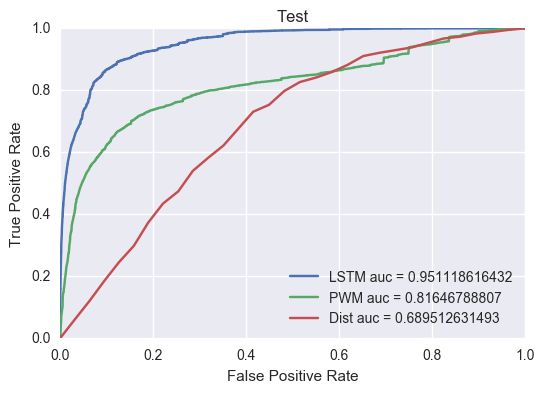

In [55]:
K=3

def roc(X, y, p, begin, end, title):
    # Enter begin, end as distance from 3'SS
    # Convert to proper index...
    begin, end = 70 - end, 70 - begin
    
    # Filter for example where BP is in range
    idx = np.sum(y[:, begin:end], axis = 1).flatten() > 0
    _y, _p, _X = y[idx], p[idx], X[idx]
    truth = _y[:, begin:end].flatten()
    
    scores = _p[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
    
    scores = pwm_pred(_X, pwm)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc))
    
    scores = dist_pred(_X, dists)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc))
    
    plt.legend(loc = 'best')
    plt.title(title)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
roc(X_train[:, :, :4], y_train, train_preds, 15, 45, 'Train')
roc(X_valid[:, :, :4], y_valid, valid_preds, 15, 45, 'Validation')
roc(X_test[:, :, :4],  y_test,  test_preds,  15, 45, 'Test')

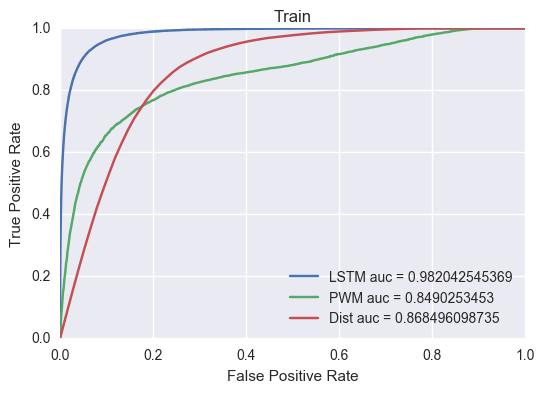

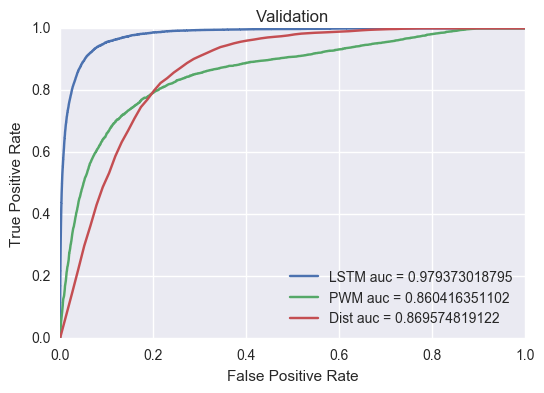

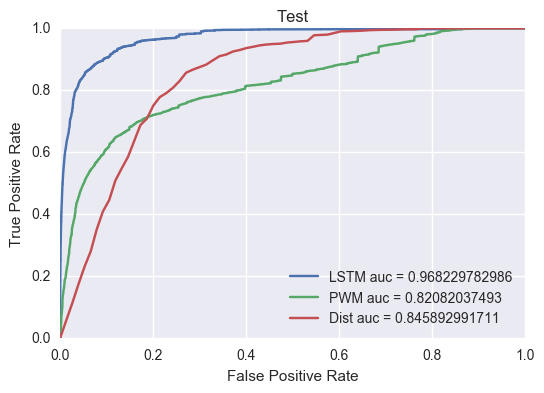

In [56]:
roc(X_train[:, :, :4], y_train, train_preds, 0, 70, 'Train')
roc(X_valid[:, :, :4], y_valid, valid_preds, 0, 70, 'Validation')
roc(X_test[:, :, :4],  y_test,  test_preds,  0, 70, 'Test')

## auPRC on train, valid, test

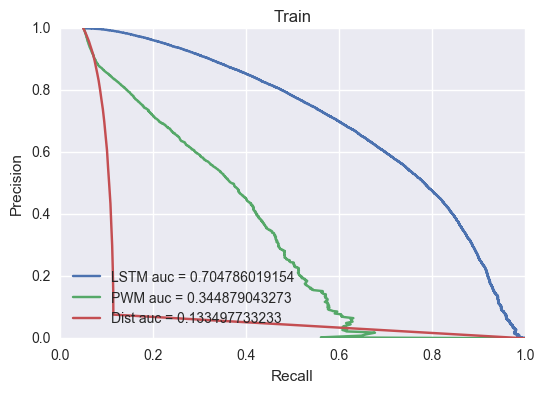

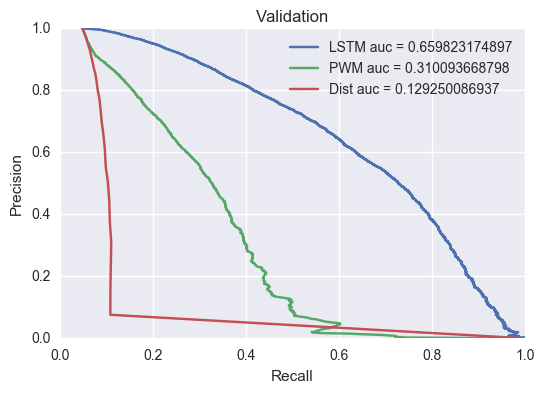

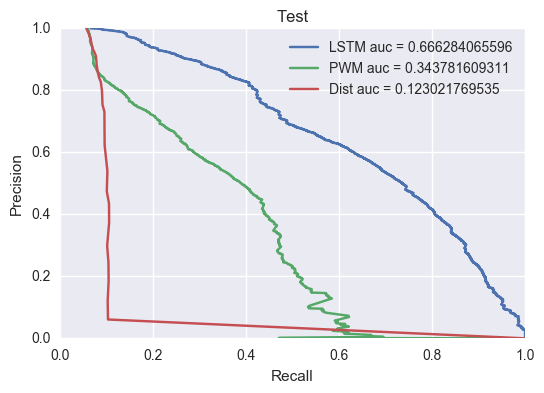

In [58]:
def prc(X, y, p, begin, end, title):
    # Enter begin, end as distance from 3'SS
    # Convert to proper index...
    begin, end = 70 - end, 70 - begin
    
    # Filter for example where BP is in range
    idx = np.sum(y[:, begin:end], axis = 1).flatten() > 0
    _y, _p, _X = y[idx], p[idx], X[idx]
    truth = _y[:, begin:end].flatten()
    
    scores = _p[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth,scores, pos_label=1)
    auc = metrics.average_precision_score(truth, scores)
    plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
    
    scores = pwm_pred(_X, pwm)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth, scores, pos_label=1)
    auc = metrics.average_precision_score(truth, scores)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc))
    
    scores = dist_pred(_X, dists)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth, scores, pos_label=1)
    auc = metrics.average_precision_score(truth, scores)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc))
    
    plt.legend(loc = 'best')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title(title)
    plt.show()
    
prc(X_train[:, :, :4], y_train, train_preds, 15, 45, 'Train')
prc(X_valid[:, :, :4], y_valid, valid_preds, 15, 45, 'Validation')
prc(X_test[:, :, :4],  y_test,  test_preds,  15, 45, 'Test')

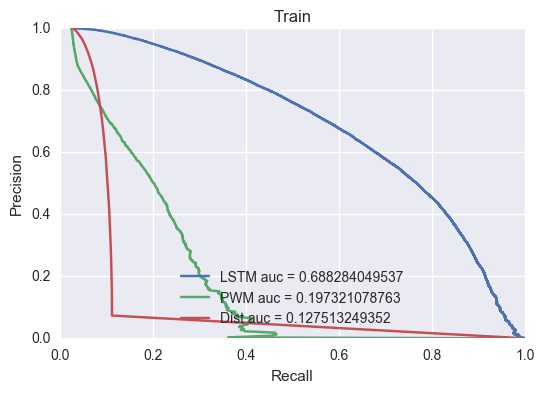

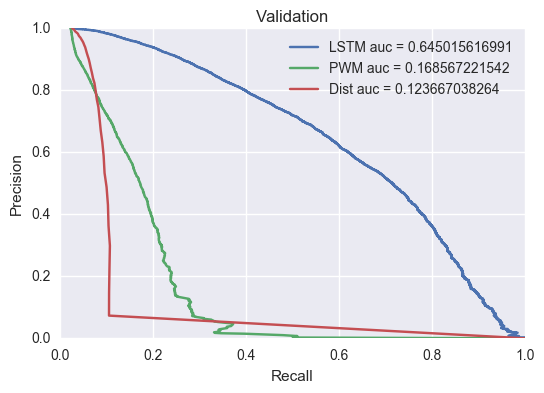

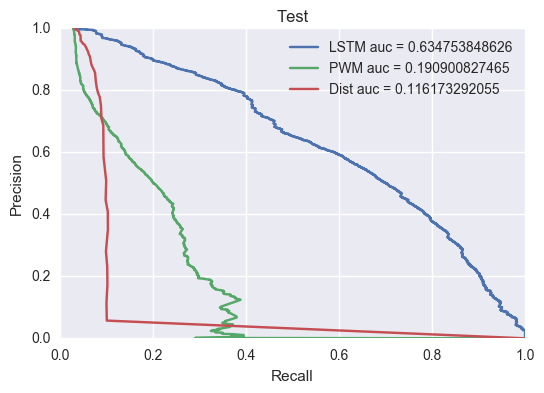

In [59]:
prc(X_train[:, :, :4], y_train, train_preds, 0, 70, 'Train')
prc(X_valid[:, :, :4], y_valid, valid_preds, 0, 70, 'Validation')
prc(X_test[:, :, :4],  y_test,  test_preds,  0, 70, 'Test')

## Matching

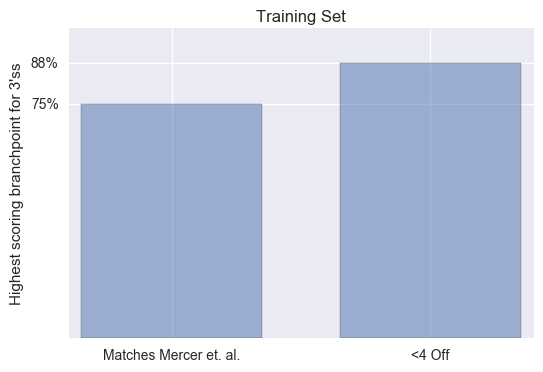

(19402, 3409, 25711)


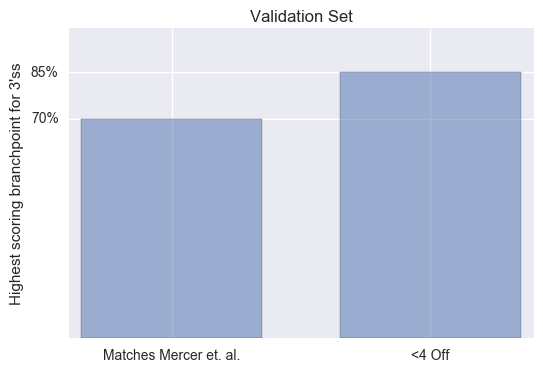

(5028, 1056, 7093)


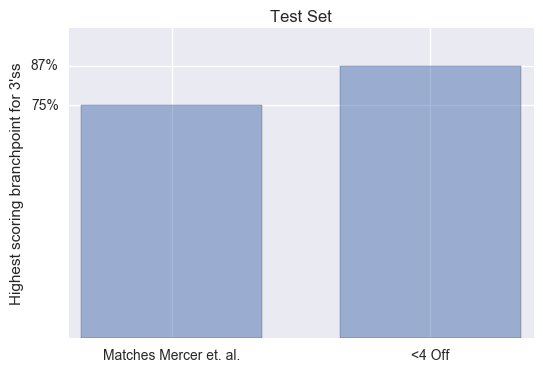

(3234, 554, 4306)


In [60]:
def shifted_matching(preds, true, title):
    E, B = 4, 4
    total, match, shifted = 0, 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        elif any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-E, np.argmax(p)+B+1)):
            shifted += 1
        total += 1
    heights = [match / float(total), (match+shifted) / float(total)]
    index = [0, .5]
    plt.bar(index, heights, .35, align = 'center', alpha = 0.5)
    plt.ylim(0, 1)
    plt.xticks(index, ['Matches Mercer et. al.', '<4 Off'])
    plt.yticks(heights, map(lambda x: "{}%".format(int(x * 100)), heights))
    plt.ylabel("Highest scoring branchpoint for 3'ss")
    plt.title(title)
    plt.show()
    return match, shifted, total

print shifted_matching(train_preds, y_train, 'Training Set')
print shifted_matching(valid_preds, y_valid, 'Validation Set')
print shifted_matching(test_preds,  y_test, 'Test Set')   

# Examples

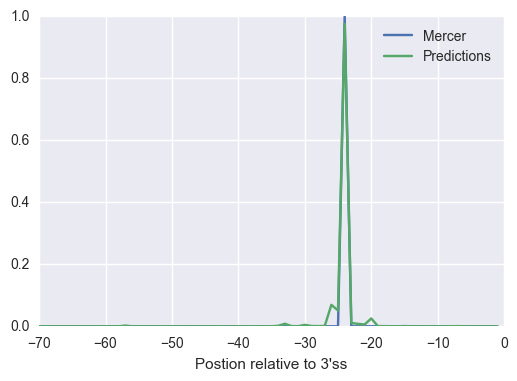

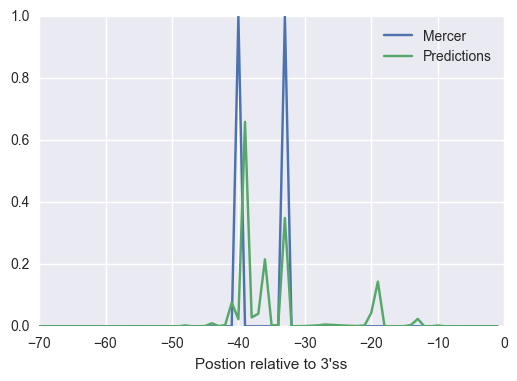

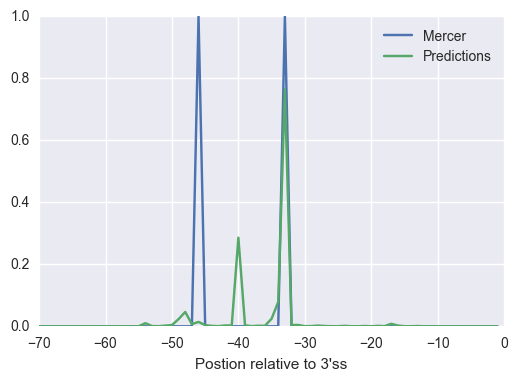

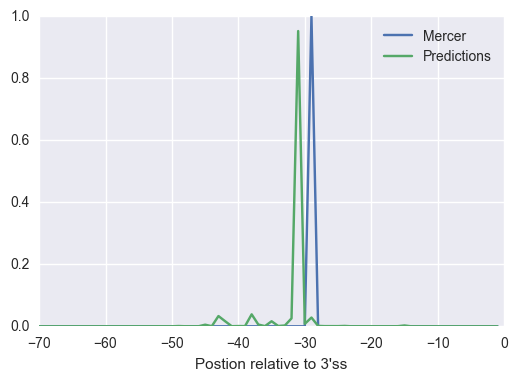

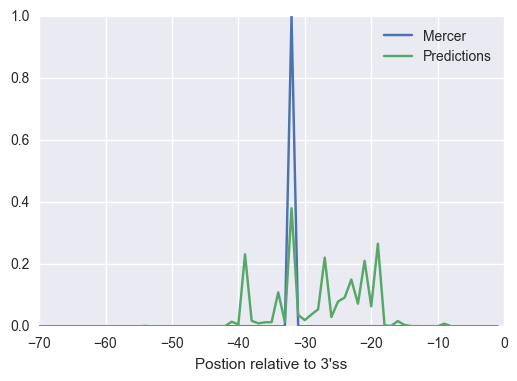

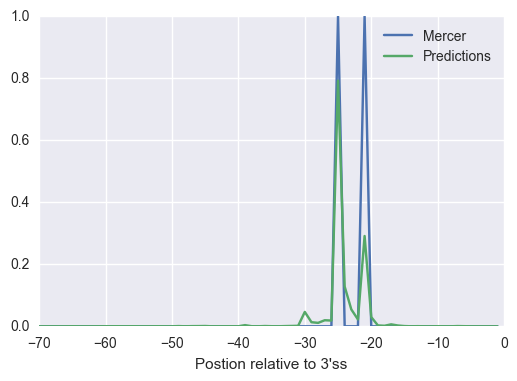

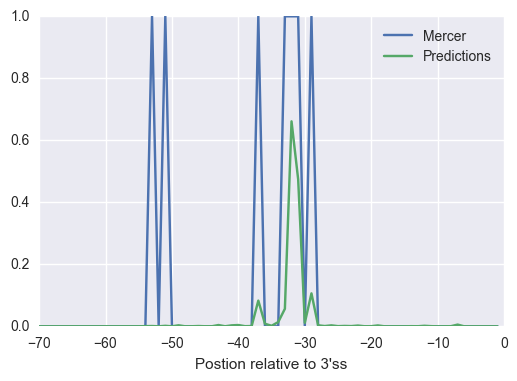

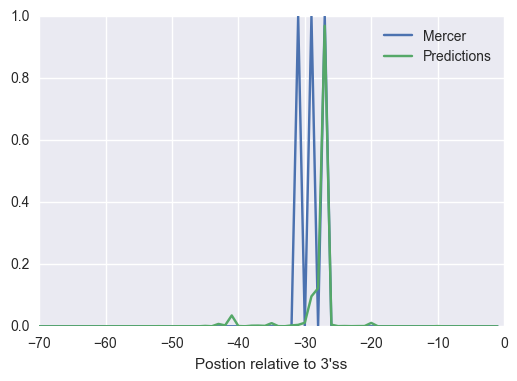

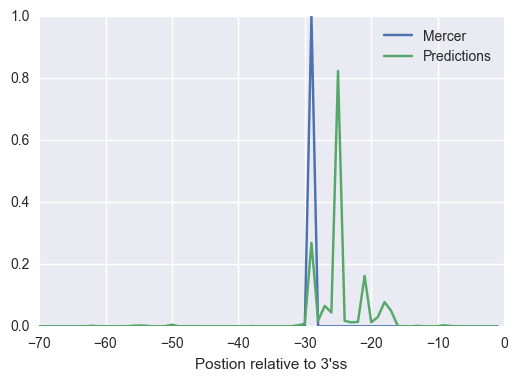

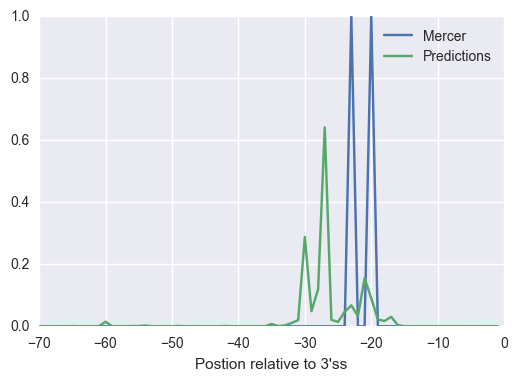

In [61]:
def plot_examples(preds, true, k = 10):
    for p, t in zip(preds[:k], true[:k]):
        plt.plot(range(-70, 0), t, label = 'Mercer')
        plt.plot(range(-70, 0), p, label = 'Predictions')
        plt.legend(loc = 'best')
        plt.xlabel("Postion relative to 3'ss")
        plt.show()
plot_examples(test_preds, y_test)

20


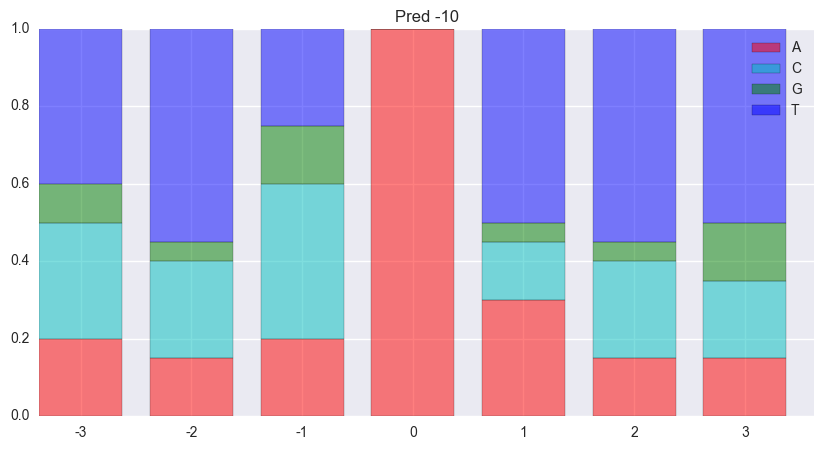

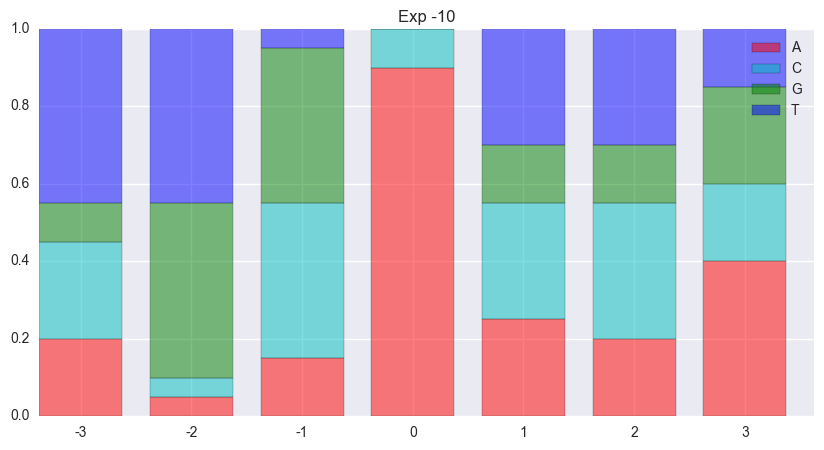

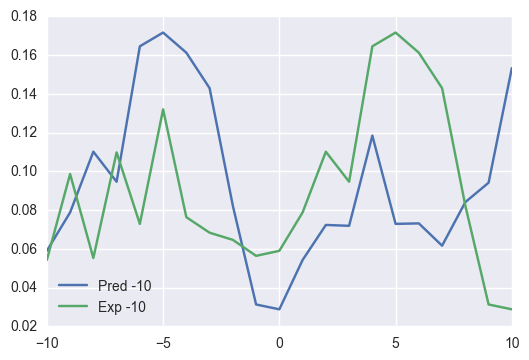

23


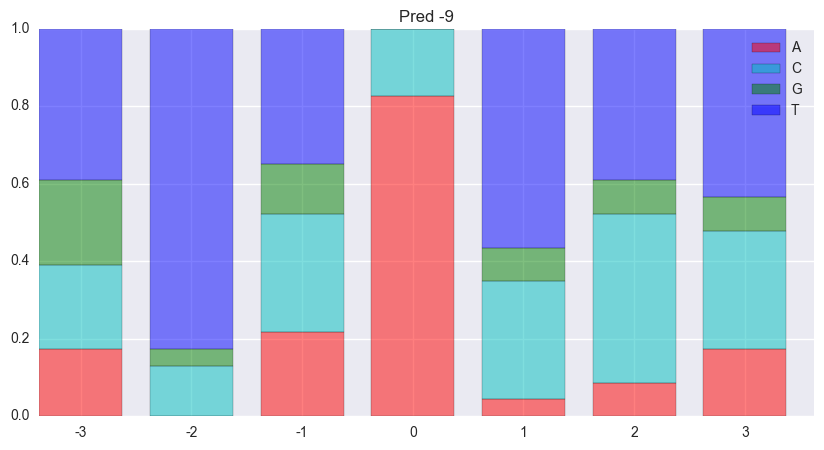

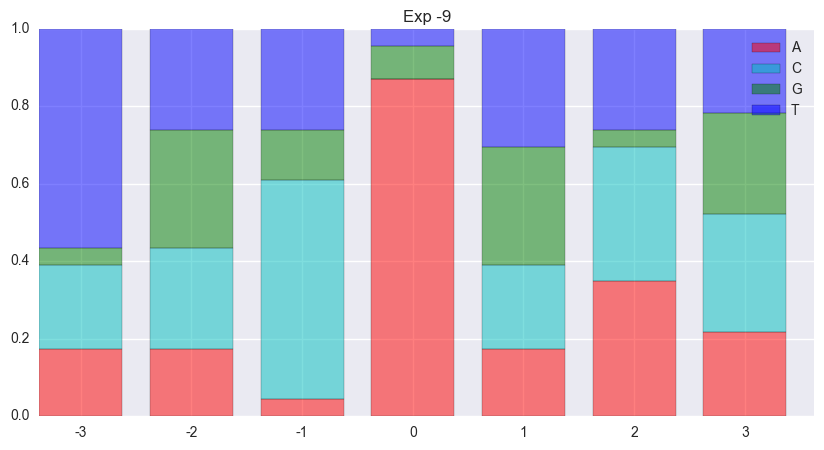

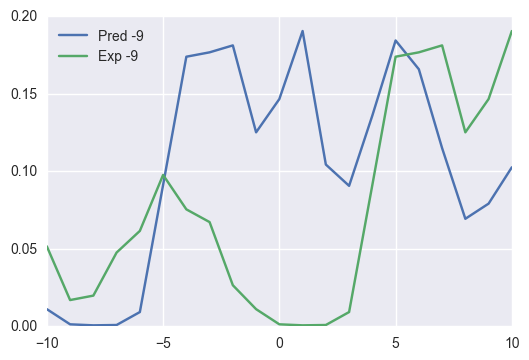

24


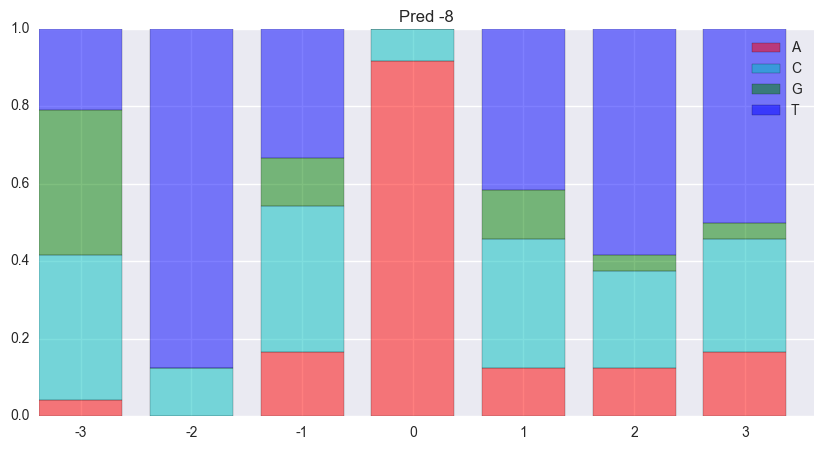

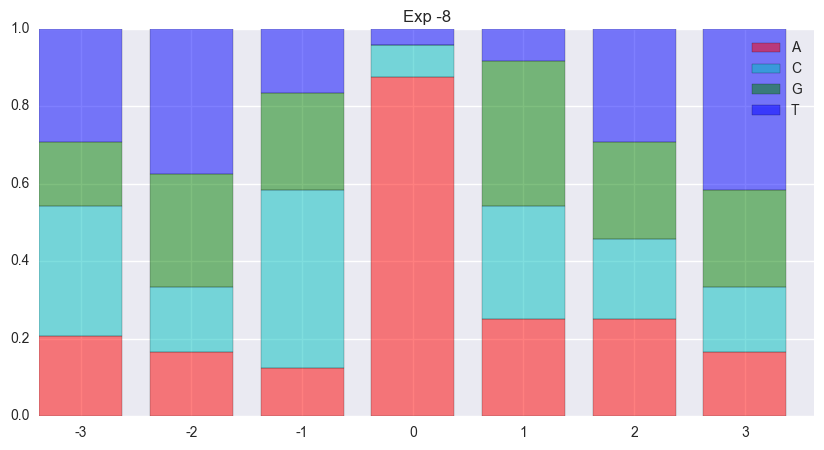

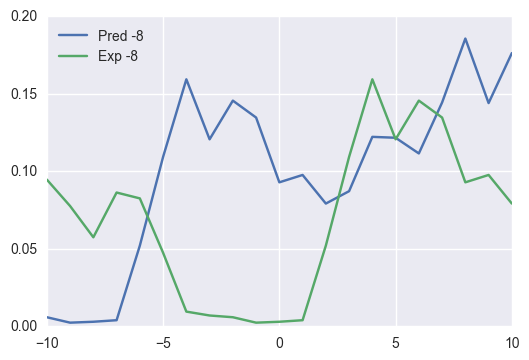

39


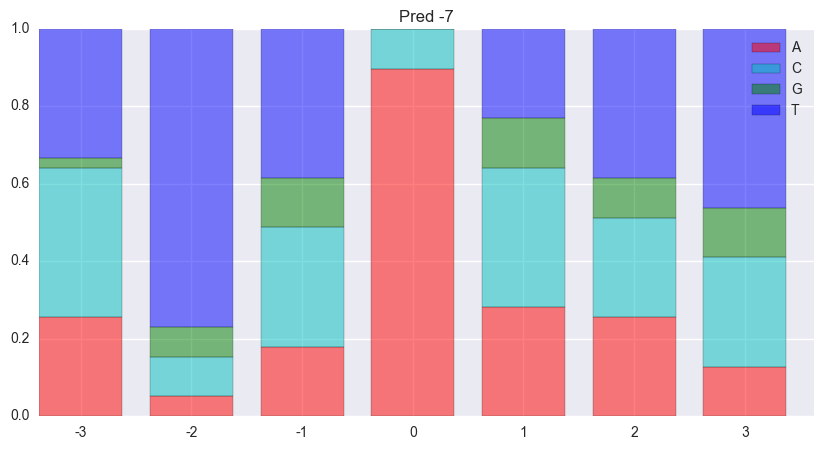

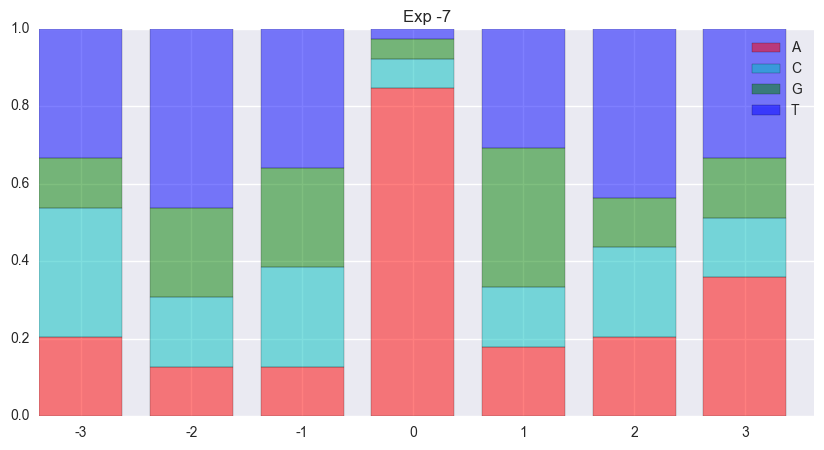

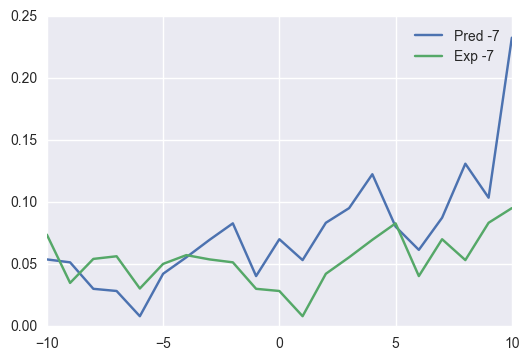

50


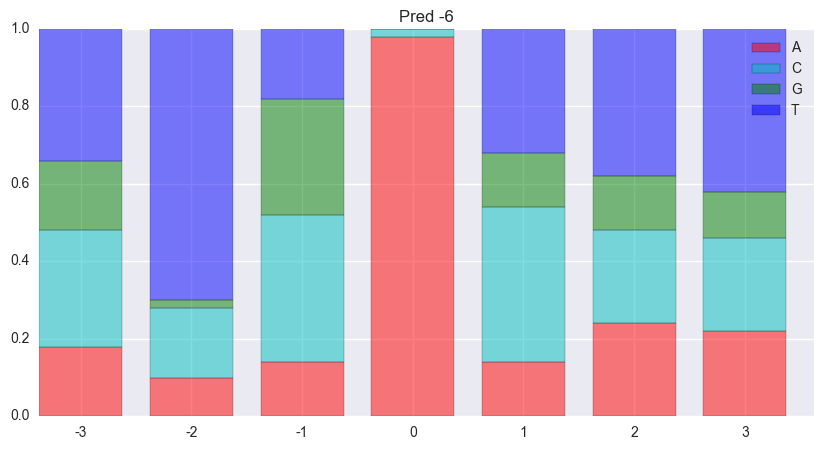

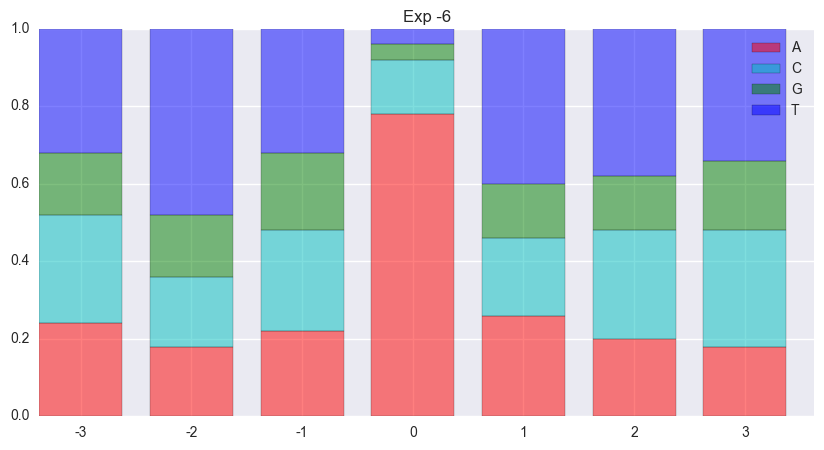

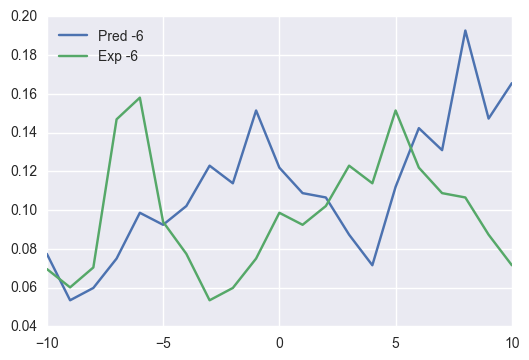

56


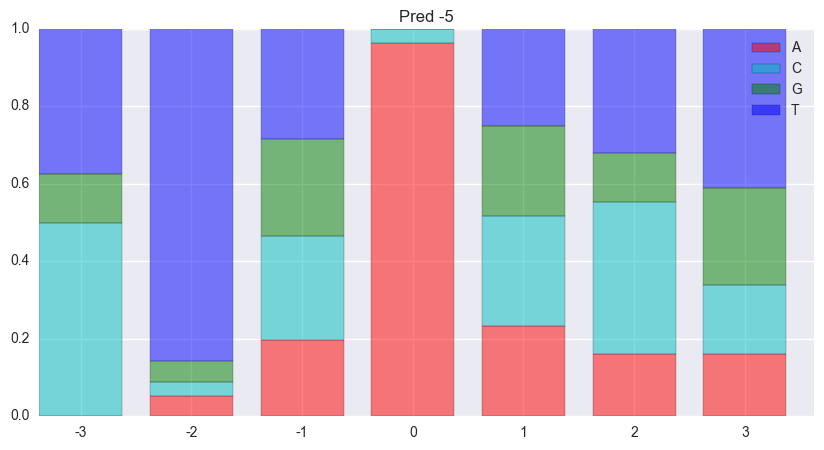

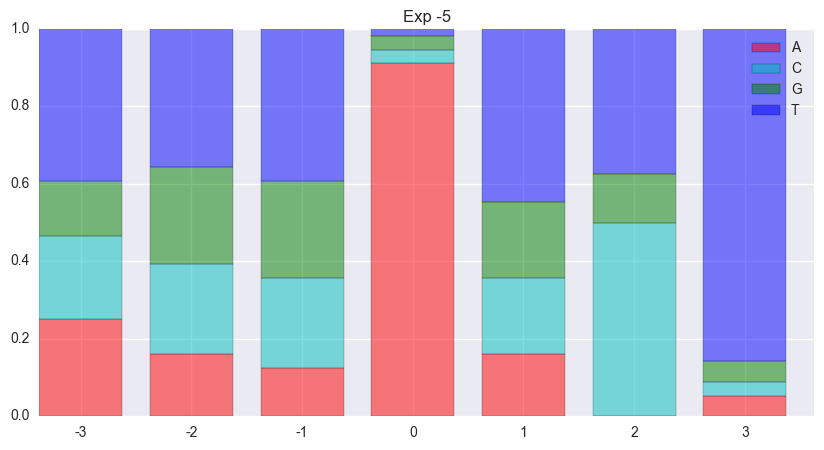

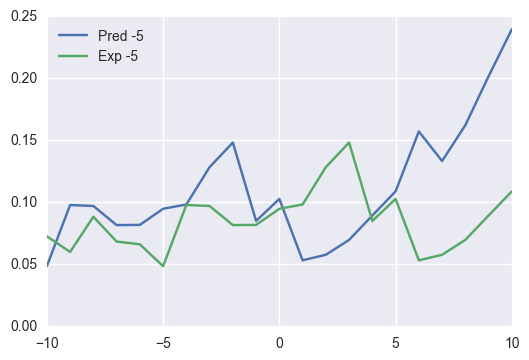

80


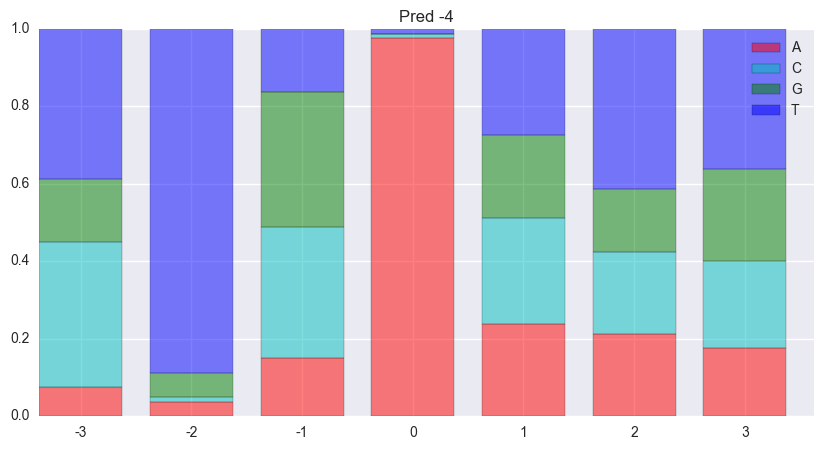

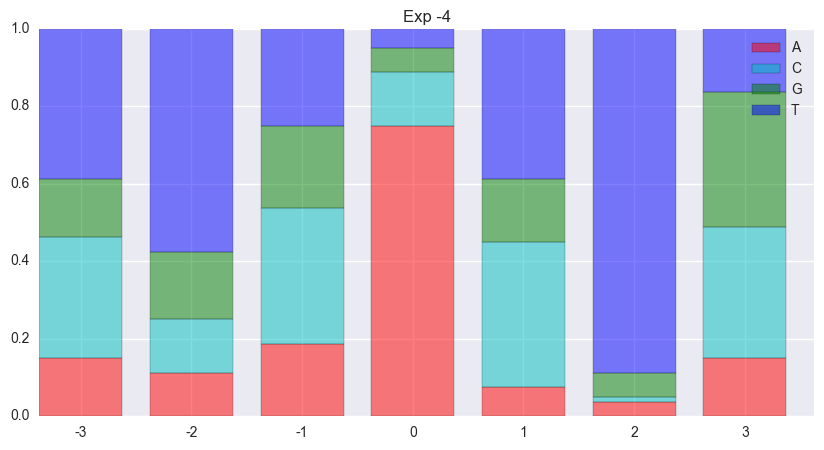

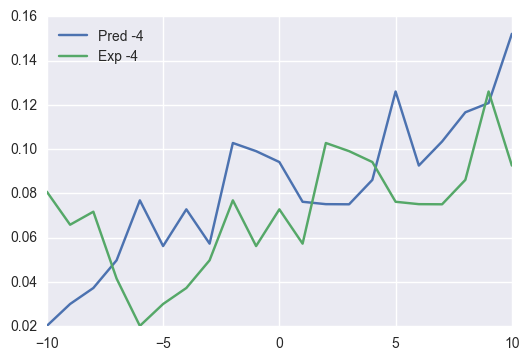

39


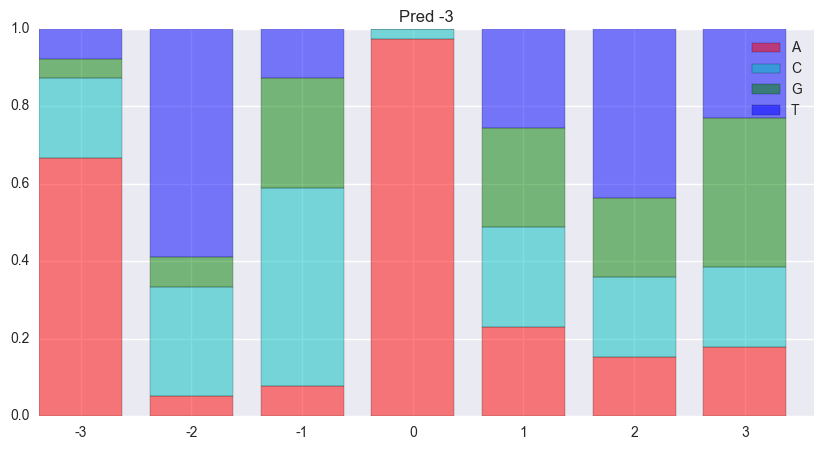

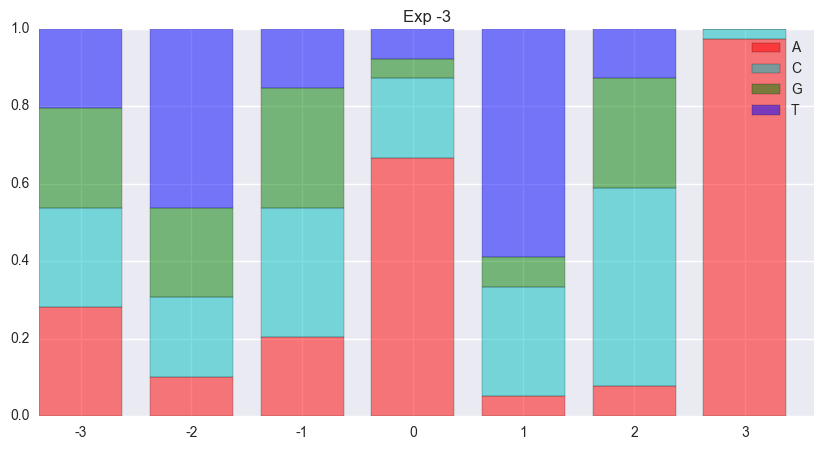

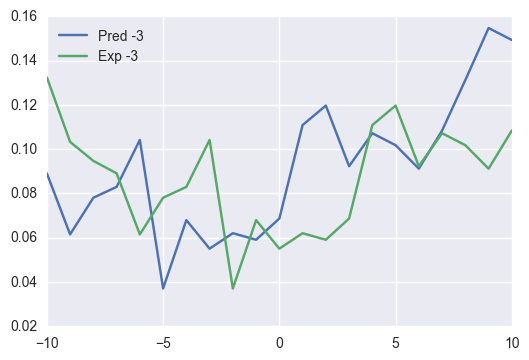

87


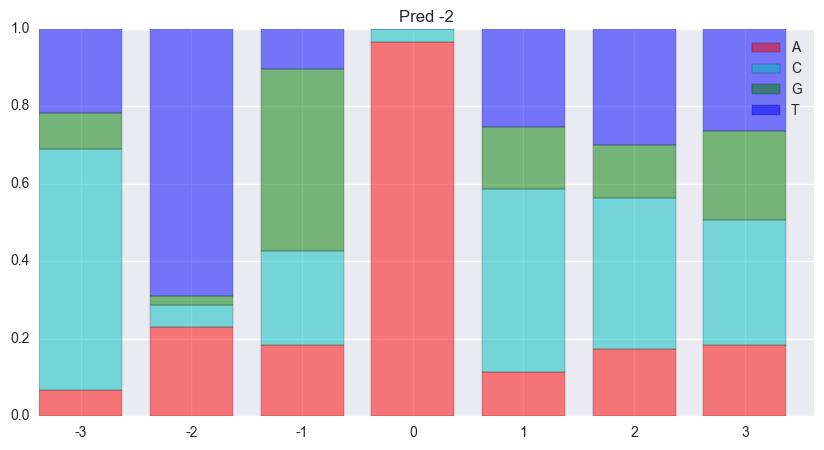

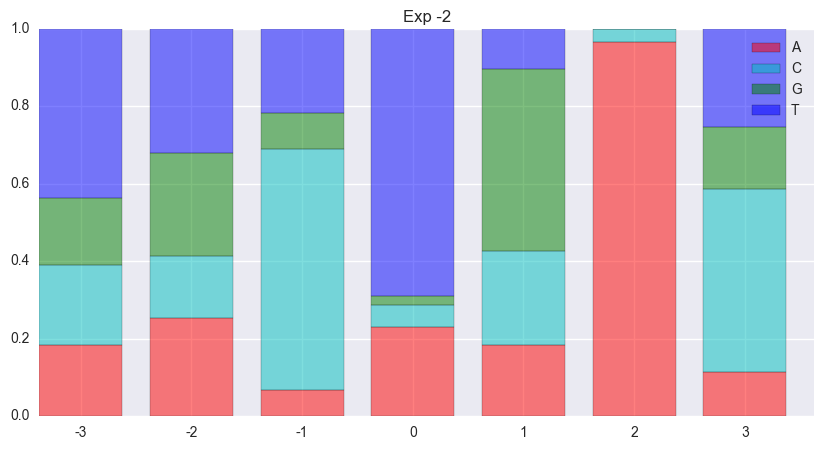

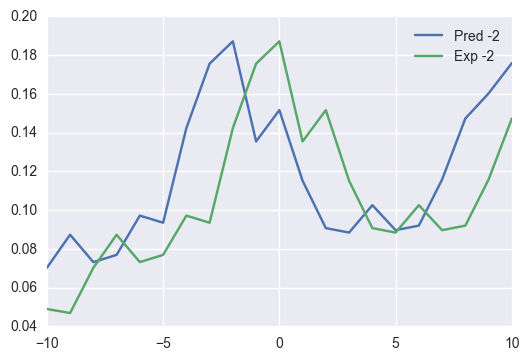

115


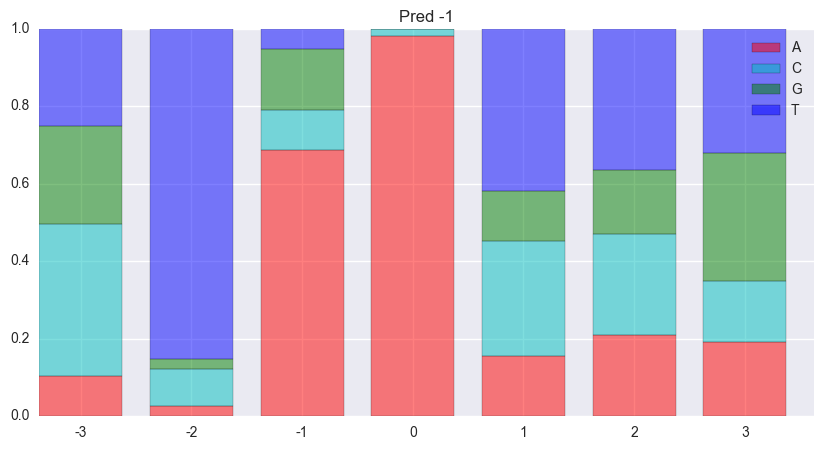

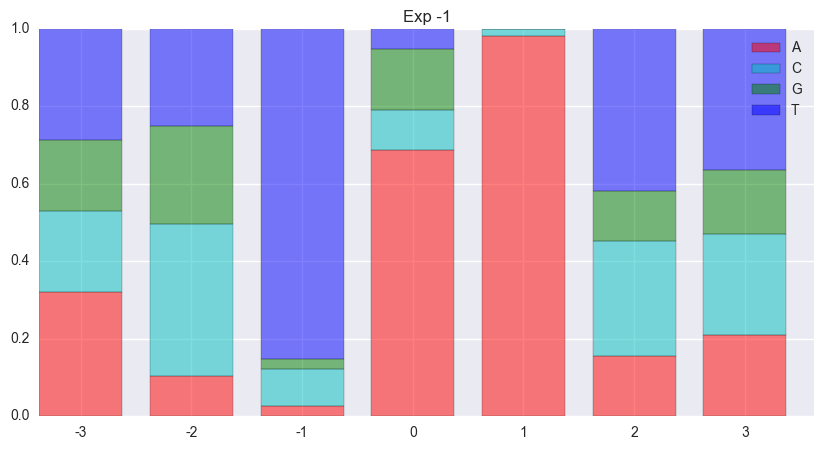

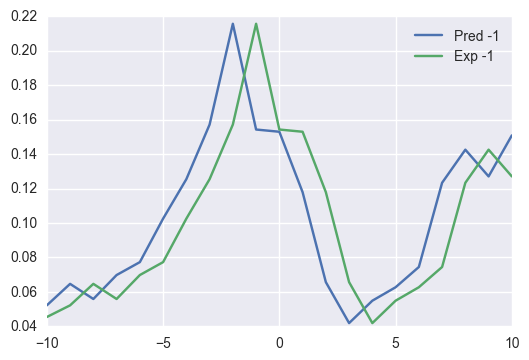

0


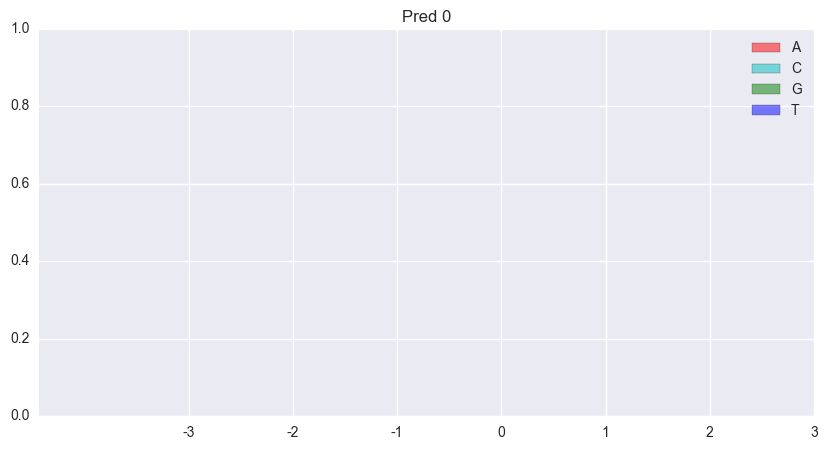

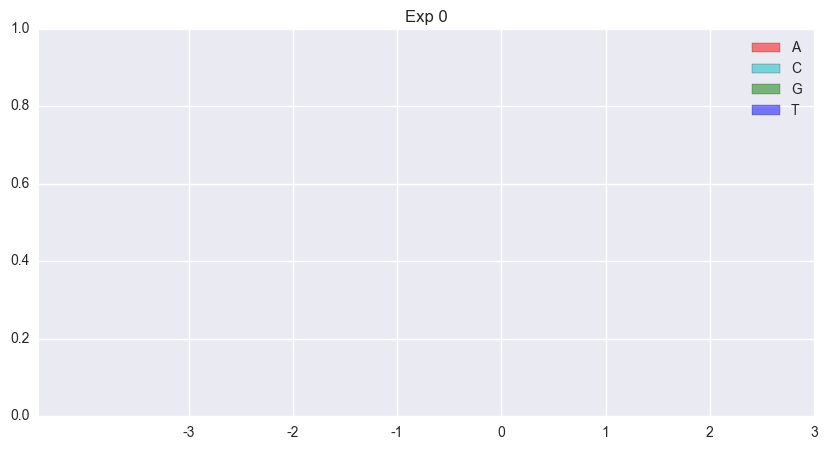

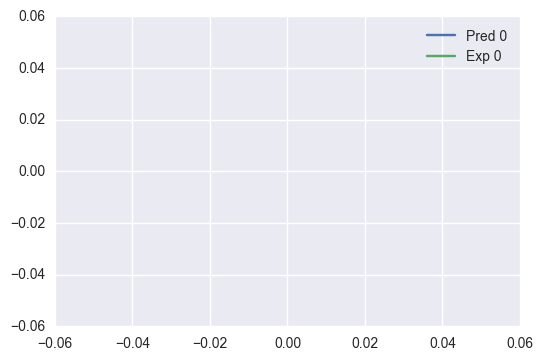

74


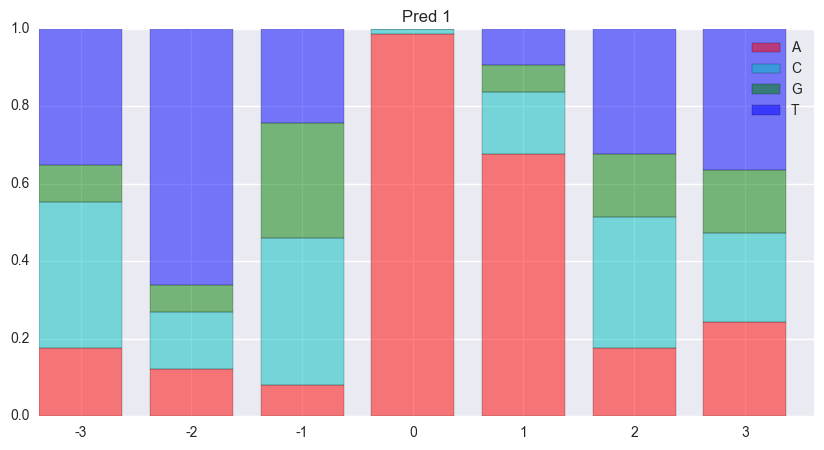

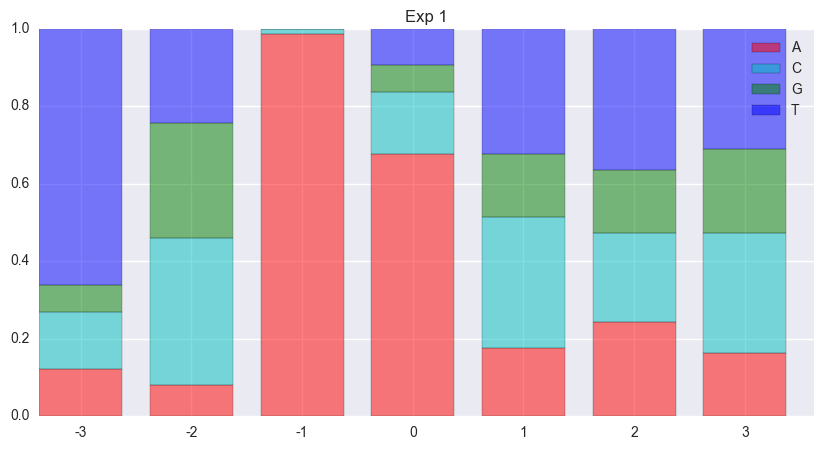

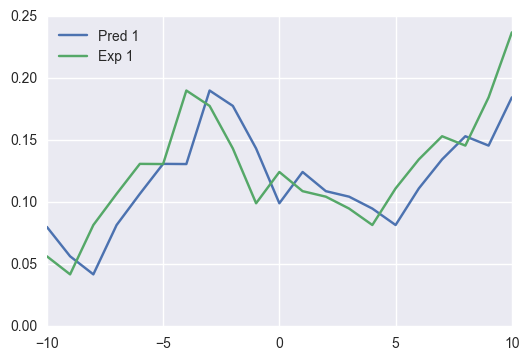

60


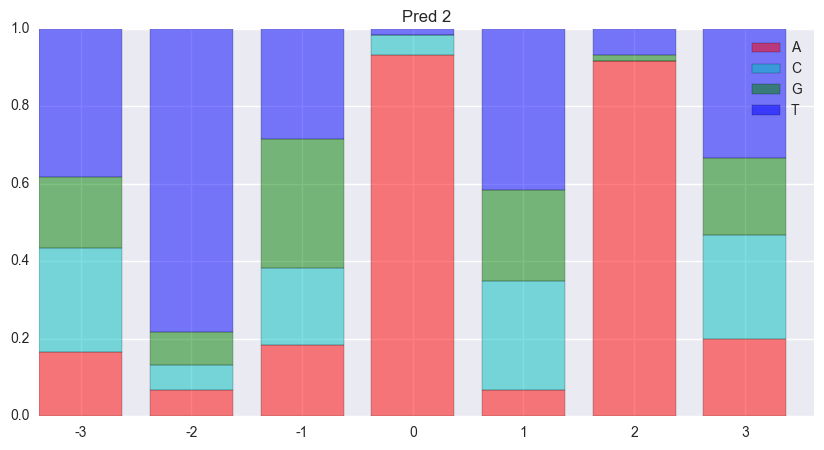

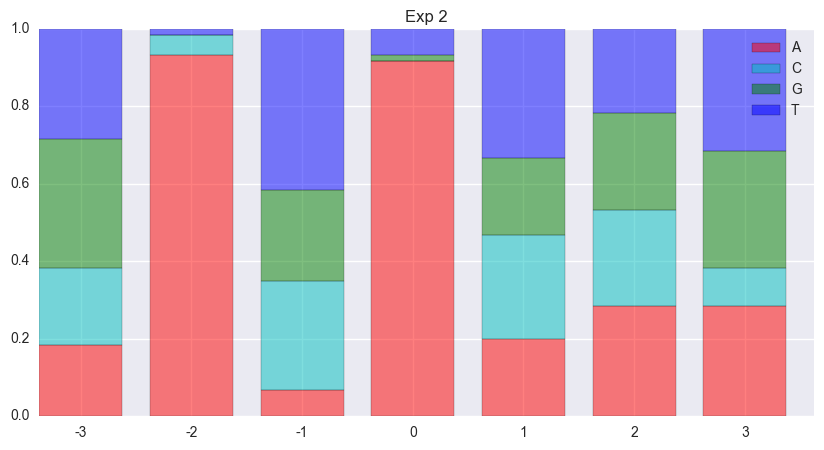

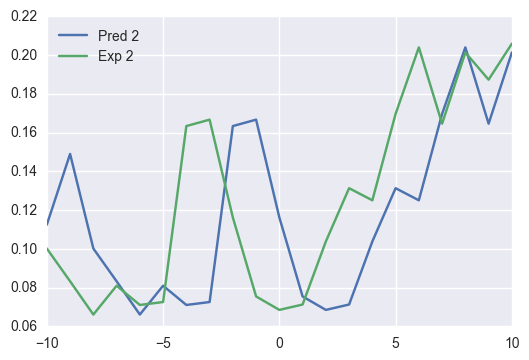

69


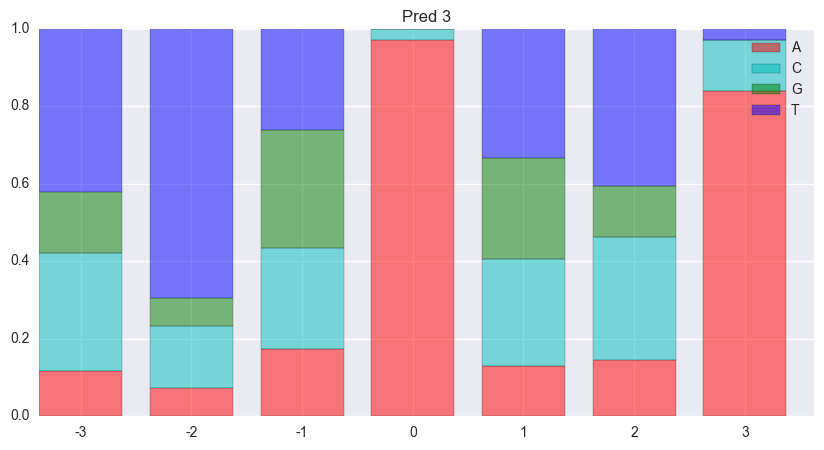

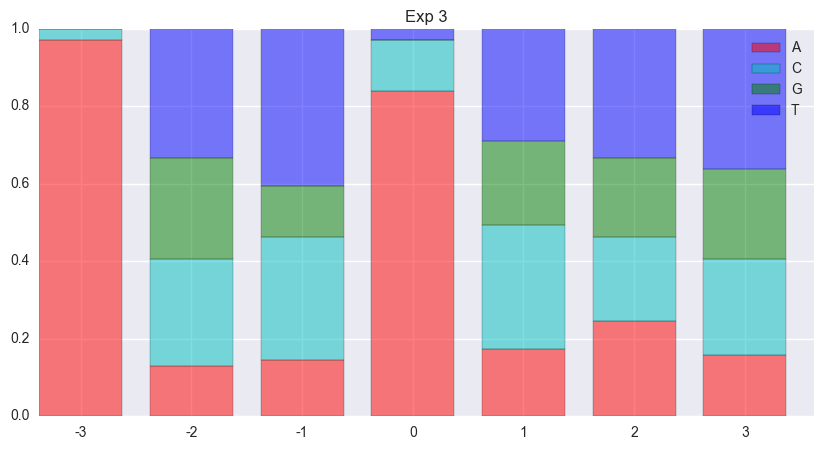

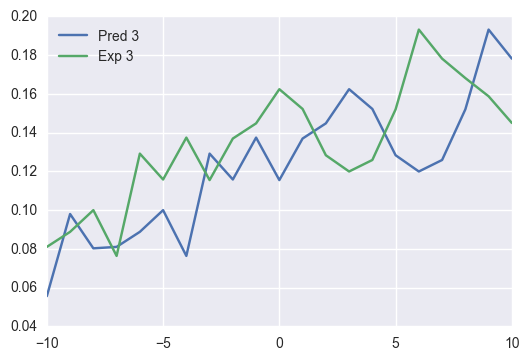

76


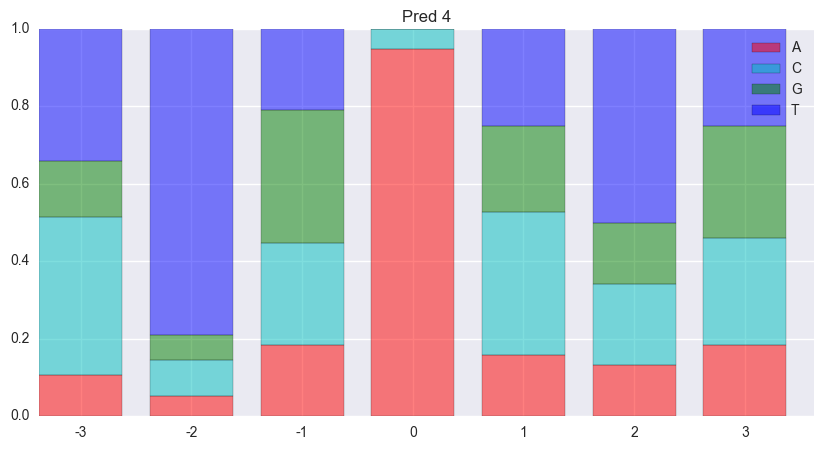

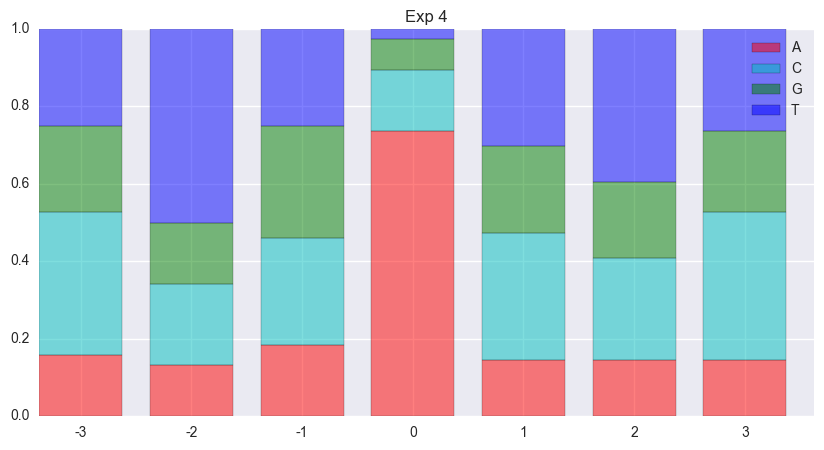

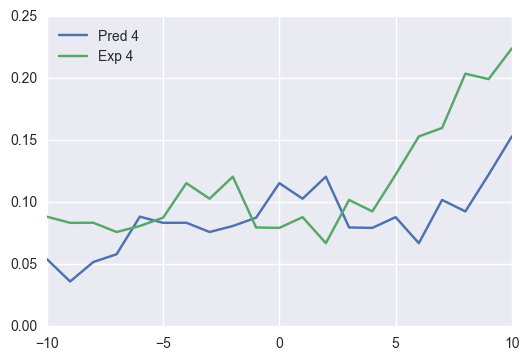

64


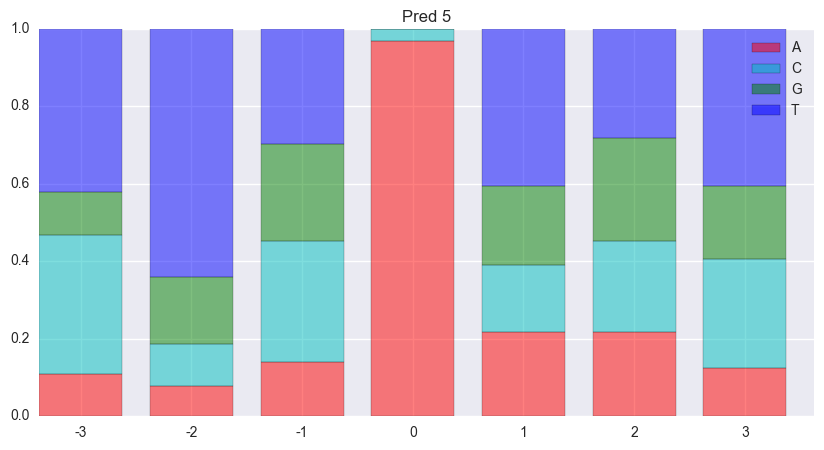

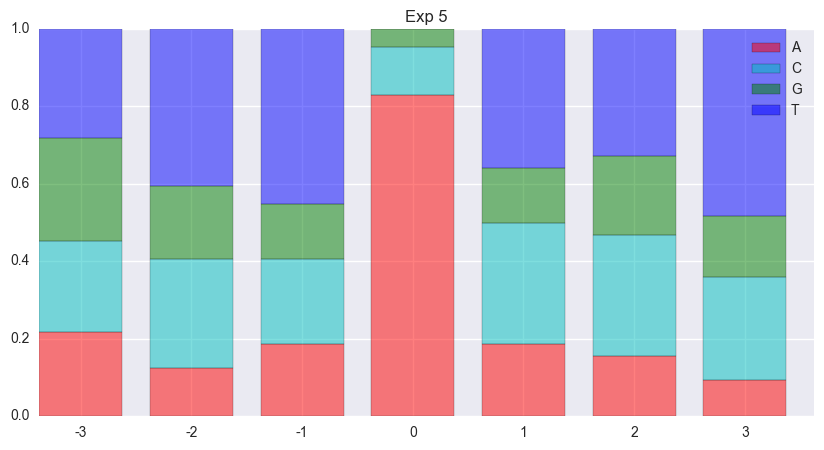

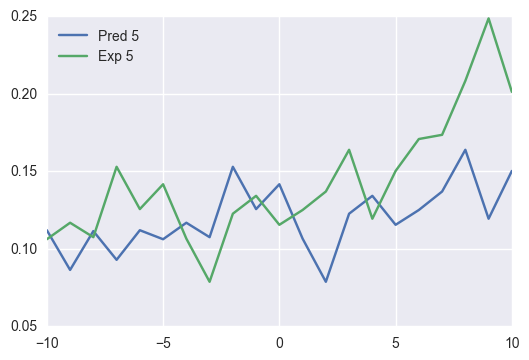

62


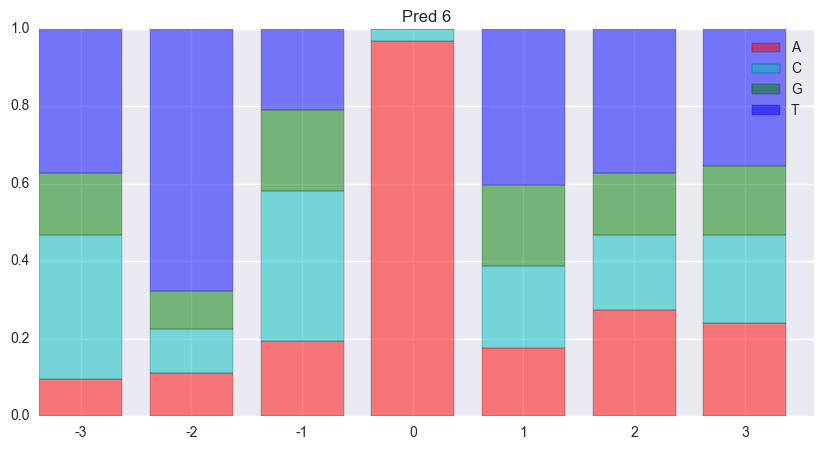

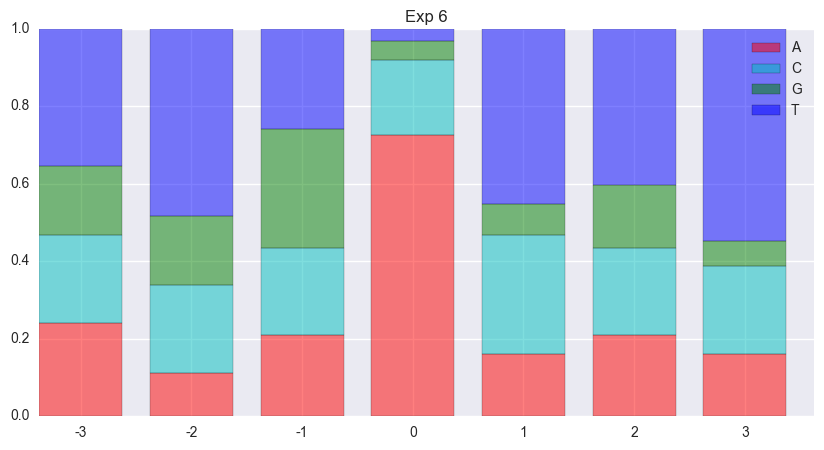

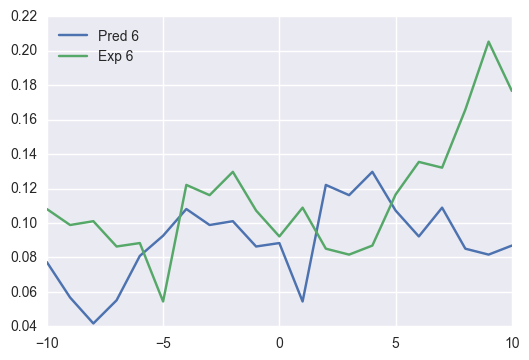

30


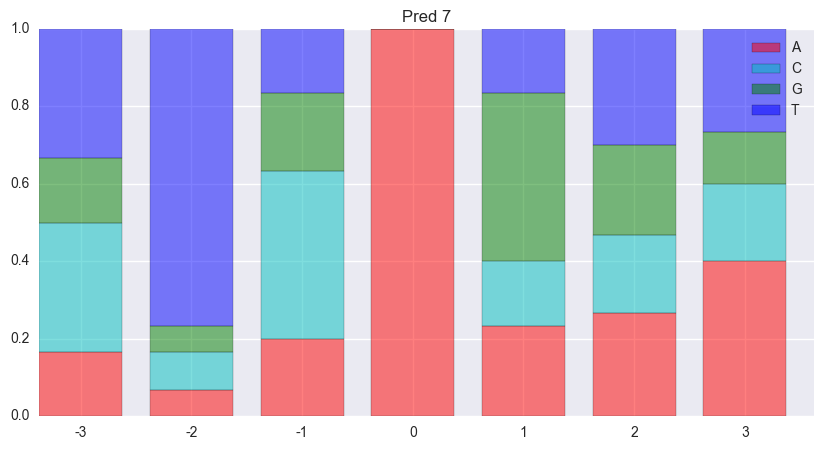

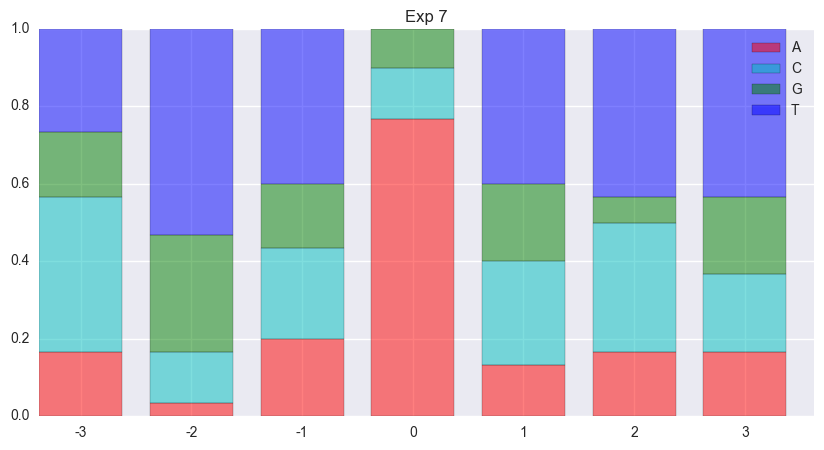

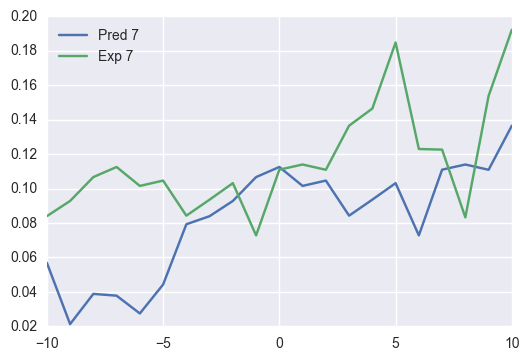

37


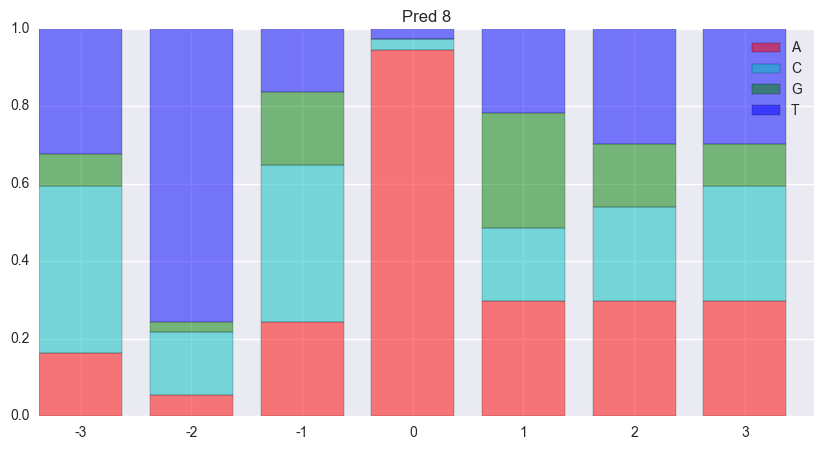

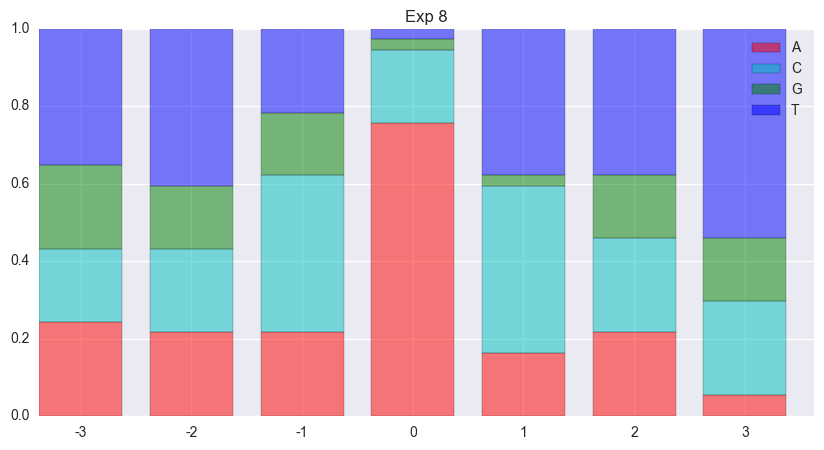

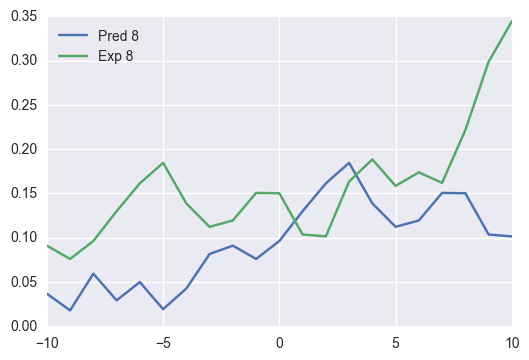

27


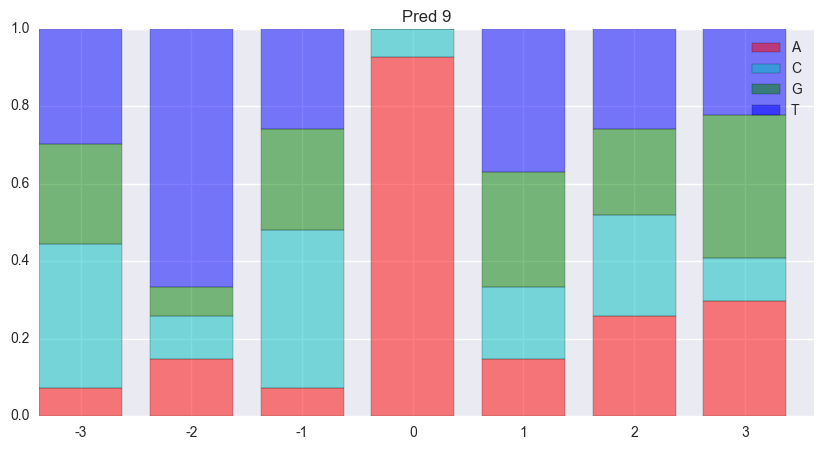

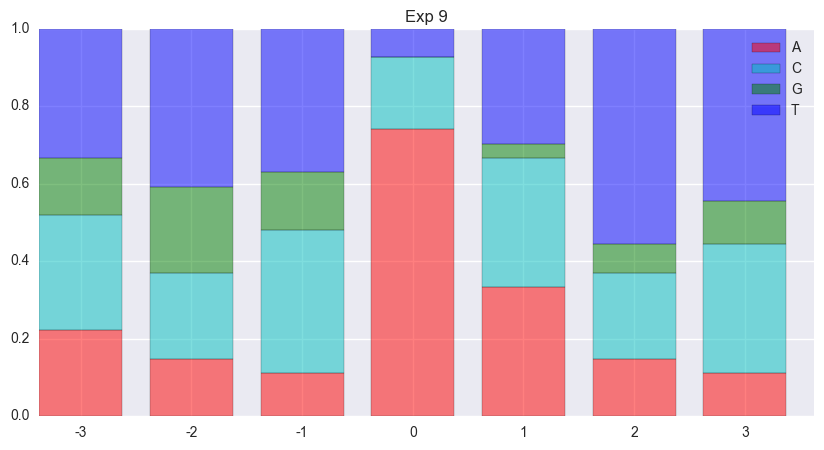

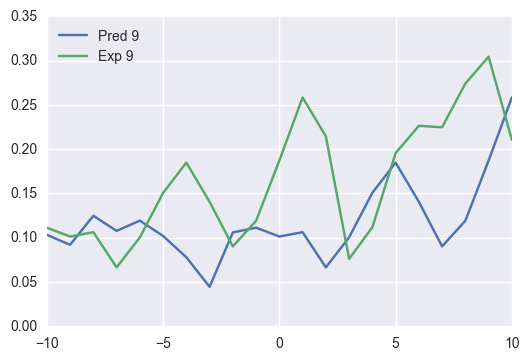

In [37]:
# For each shift, build a pwm centered on prediction
K, C = 3, 10
for offset in range(-10, 10):
    counts1 = np.zeros((2*K+1, 4))
    counts2 = np.zeros((2*K+1, 4))
    cons1 = np.zeros((2*C+1,))
    cons2 = np.zeros((2*C+1,))
    total = 0
    for p, t, seq in zip(test_preds, y_test, X_test):
        if np.argmax(p) in np.nonzero(t)[0]: continue
        if np.argmax(p)+offset in np.nonzero(t)[0]:
            bp = np.argmax(p)
            if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
            counts1 = counts1 + seq[bp-K: bp+K+1, :4]
            cons1 = cons1 + seq[bp-C:bp+C+1, 4]
            
            bp = np.argmax(p)+offset
            if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
            counts2 = counts2 + seq[bp-K: bp+K+1, :4]
            cons2 = cons2 + seq[bp-C:bp+C+1, 4]
            
            total += 1
    print total
    pwm_logo(counts1 / total, "Pred {}".format(offset))
    pwm_logo(counts2 / total, "Exp {}".format(offset))
    plt.plot(range(-C, C+1), cons1 / total, label = "Pred {}".format(offset))
    plt.plot(range(-C, C+1), cons2 / total, label = "Exp {}".format(offset))
    plt.legend(loc = 'best')
    plt.show()

227
510


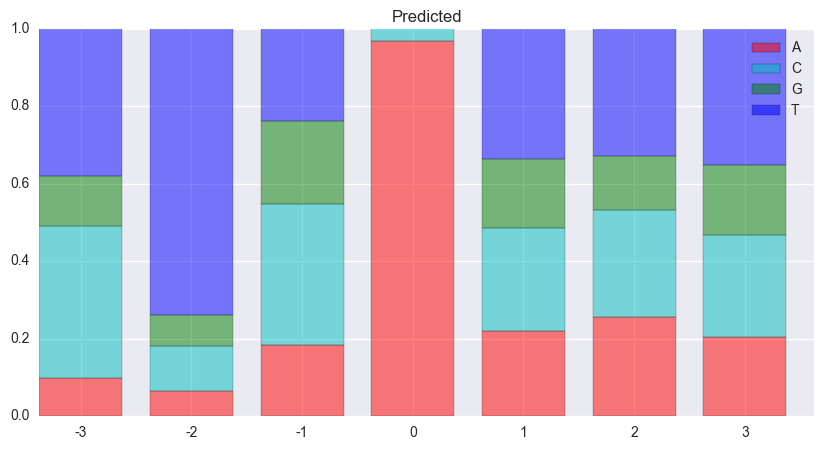

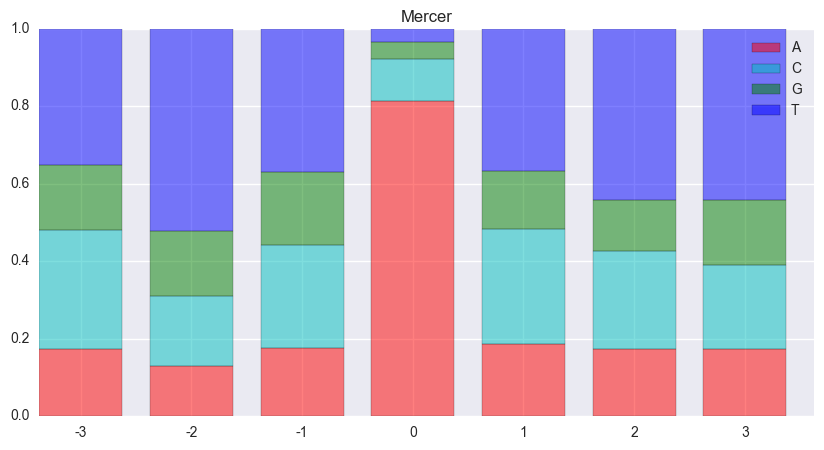

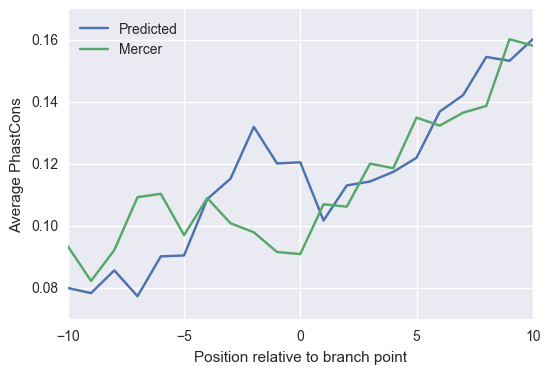

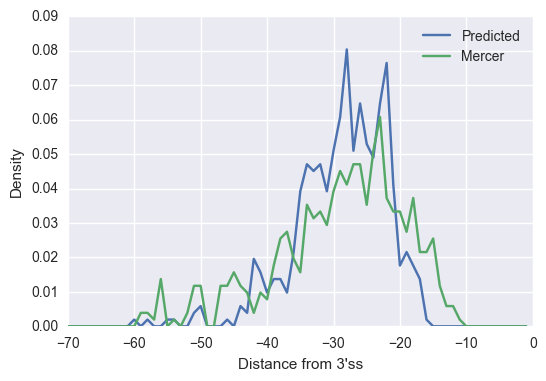

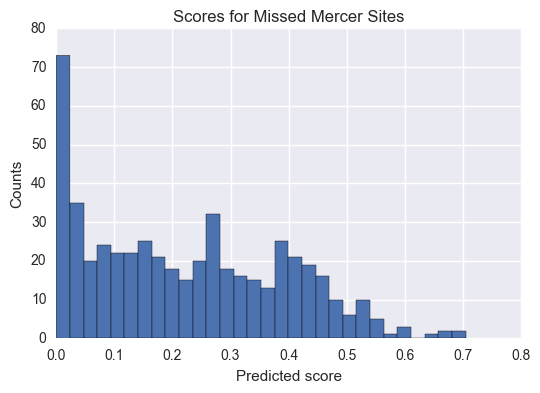

In [38]:
# For each shift, build a pwm centered on prediction
K, C = 3, 10
counts1 = np.zeros((2*K+1, 4))
counts2 = np.zeros((2*K+1, 4))
cons1 = np.zeros((2*C+1,))
cons2 = np.zeros((2*C+1,))
dist1 = np.zeros((L,))
dist2 = np.zeros((L,))
scores = []
second = 0
total = 0
for p, t, seq in zip(test_preds, y_test, X_test):
    if any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-4, np.argmax(p) + 5)): continue
    bp = np.argmax(p)
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts1 = counts1 + seq[bp-K: bp+K+1, :4]
    cons1 = cons1 + seq[bp-C:bp+C+1, 4]
    dist1[bp] += 1

    bp = np.nonzero(t)[0][-1]
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts2 = counts2 + seq[bp-K: bp+K+1, :4]
    cons2 = cons2 + seq[bp-C:bp+C+1, 4]
    dist2[bp] += 1
    
    
    scores += [p[bp, 0]]
    second += sum(scores[-1] < p.flatten()) == 1

    total += 1
print second
print total
pwm_logo(counts1 / total, "Predicted")
pwm_logo(counts2 / total, "Mercer")
plt.plot(range(-C, C+1), cons1 / total, label = "Predicted")
plt.plot(range(-C, C+1), cons2 / total, label = "Mercer")
plt.legend(loc = 'best')
plt.ylabel('Average PhastCons')
plt.xlabel('Position relative to branch point')
plt.show()

plt.plot(range(-70, 0), dist1 / total, label = "Predicted")
plt.plot(range(-70, 0), dist2 / total, label = "Mercer")
plt.legend(loc = 'best')
plt.ylabel('Density')
plt.xlabel("Distance from 3'ss")
plt.show()

plt.hist(scores, bins = 30)
plt.title('Scores for Missed Mercer Sites')
plt.ylabel('Counts')
plt.xlabel('Predicted score')
plt.show()

227
510


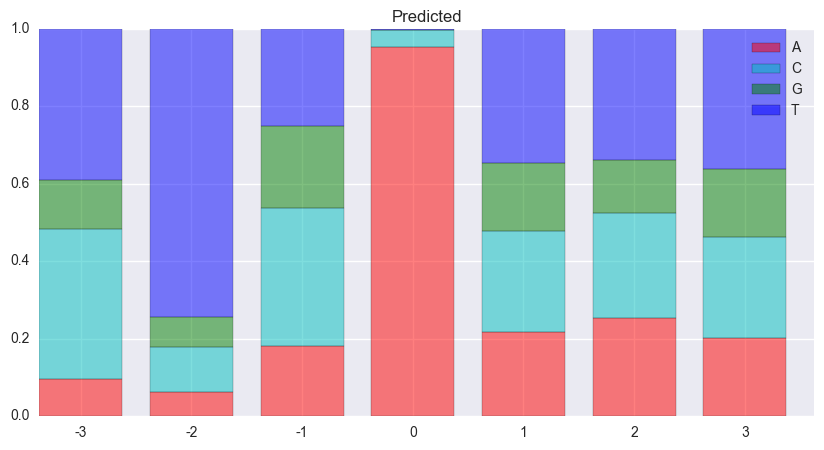

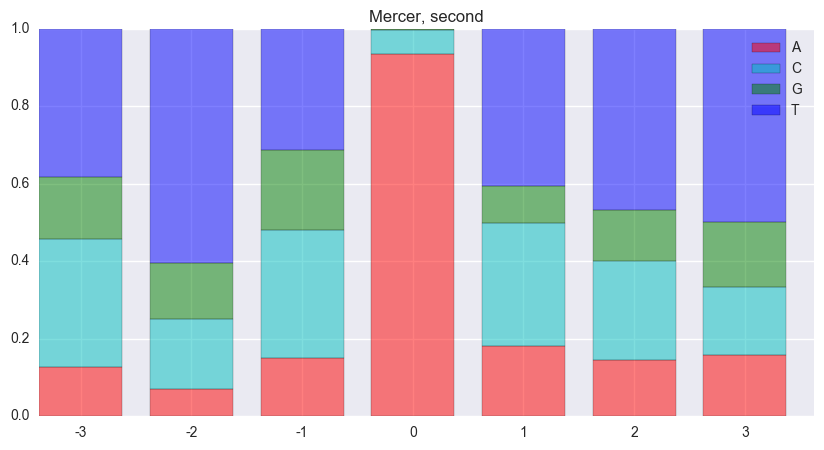

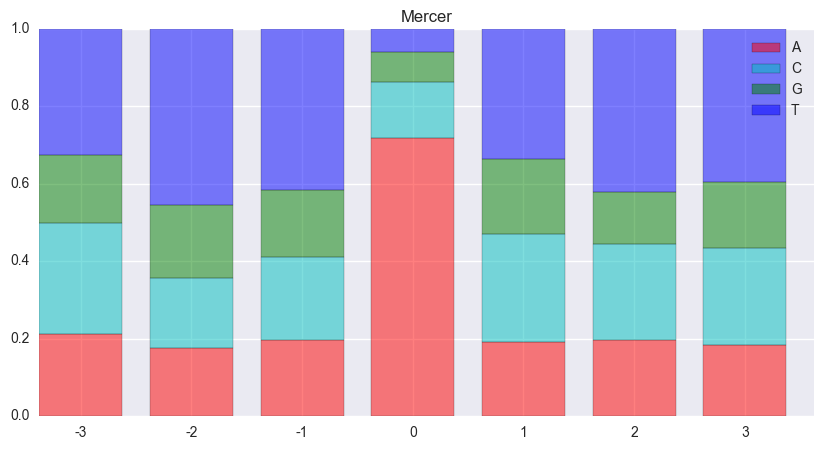

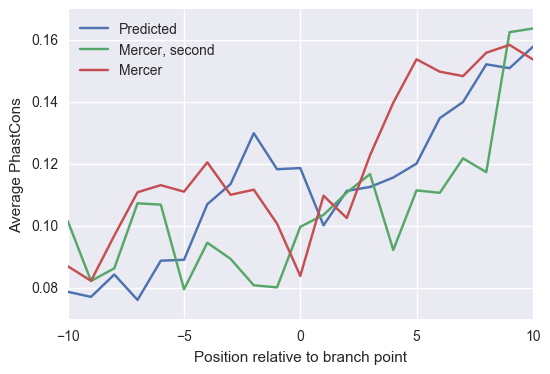

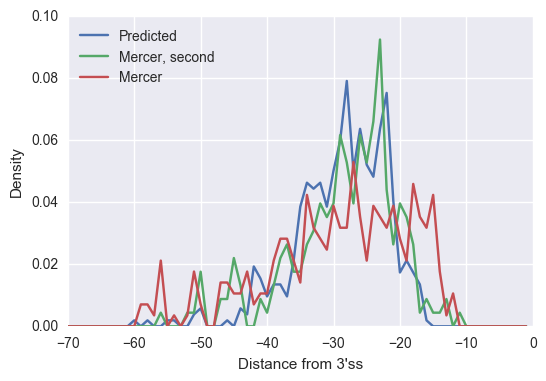

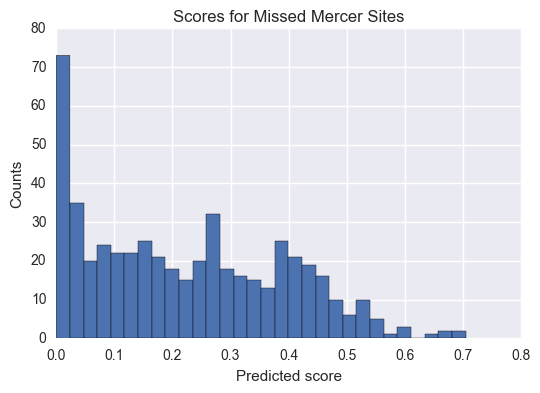

In [39]:
# For each shift, build a pwm centered on prediction
K, C = 3, 10
counts1 = np.zeros((2*K+1, 4))
counts2 = np.zeros((2*K+1, 4))
counts3 = np.zeros((2*K+1, 4))
cons1 = np.zeros((2*C+1,))
cons2 = np.zeros((2*C+1,))
cons3 = np.zeros((2*C+1,))
dist1 = np.zeros((L,))
dist2 = np.zeros((L,))
dist3 = np.zeros((L,))
scores = []
second = 0
total1, total2, total3 = 0, 0, 0
for p, t, seq in zip(test_preds, y_test, X_test):
    if any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-4, np.argmax(p) + 5)): continue
    bp = np.argmax(p)
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts1 = counts1 + seq[bp-K: bp+K+1, :4]
    cons1 = cons1 + seq[bp-C:bp+C+1, 4]
    dist1[bp] += 1
    total1 += 1

    bp = np.nonzero(t)[0][-1]
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    
    scores += [p[bp, 0]]
    second += sum(scores[-1] < p.flatten()) == 1
        
    if sum(scores[-1] < p.flatten()) == 1:
        counts2 = counts2 + seq[bp-K: bp+K+1, :4]
        cons2 = cons2 + seq[bp-C:bp+C+1, 4]
        dist2[bp] += 1
        total2 += 1
    else:
        counts3 = counts3 + seq[bp-K: bp+K+1, :4]
        cons3 = cons3 + seq[bp-C:bp+C+1, 4]
        dist3[bp] += 1
        total3 += 1

    
print second
print total
pwm_logo(counts1 / total1, "Predicted")
pwm_logo(counts2 / total2, "Mercer, second")
pwm_logo(counts3 / total3, "Mercer")


plt.plot(range(-C, C+1), cons1 / total1, label = "Predicted")
plt.plot(range(-C, C+1), cons2 / total2, label = "Mercer, second")
plt.plot(range(-C, C+1), cons3 / total3, label = "Mercer")
plt.legend(loc = 'best')
plt.ylabel('Average PhastCons')
plt.xlabel('Position relative to branch point')
plt.show()

plt.plot(range(-70, 0), dist1 / total1, label = "Predicted")
plt.plot(range(-70, 0), dist2 / total2, label = "Mercer, second")
plt.plot(range(-70, 0), dist3 / total3, label = "Mercer")
plt.legend(loc = 'best')
plt.ylabel('Density')
plt.xlabel("Distance from 3'ss")
plt.show()

plt.hist(scores, bins = 30)
plt.title('Scores for Missed Mercer Sites')
plt.ylabel('Counts')
plt.xlabel('Predicted score')
plt.show()

553


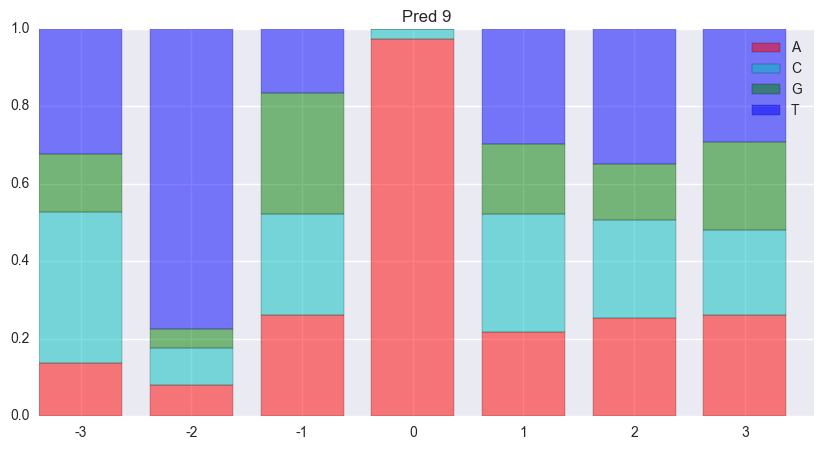

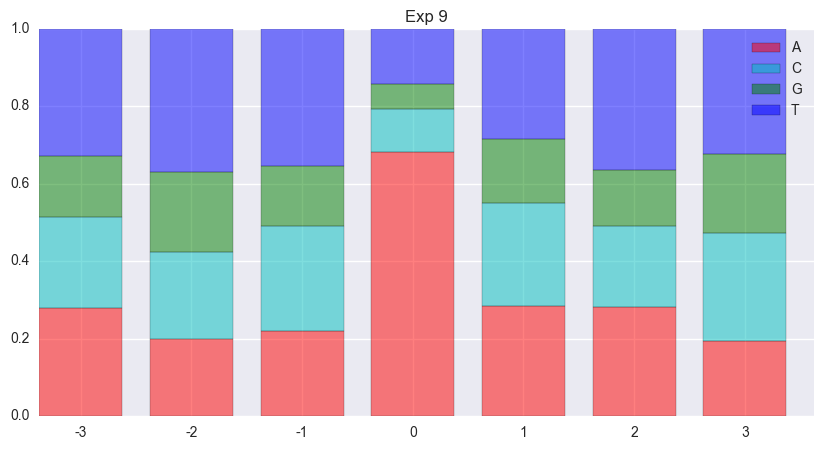

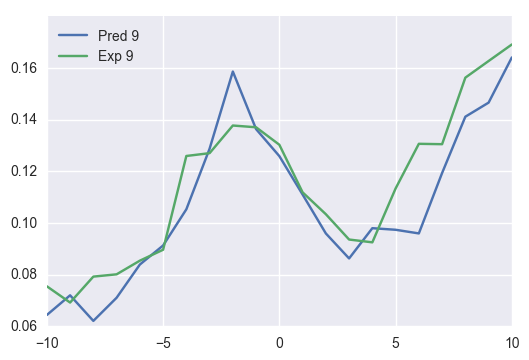

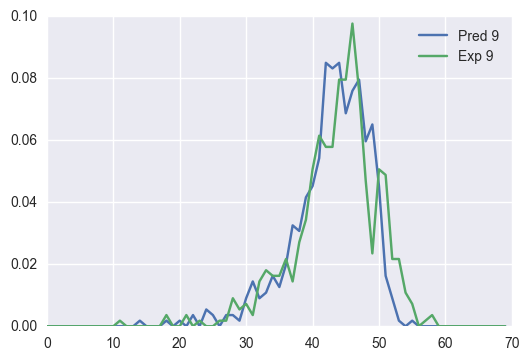

In [40]:
# For each shift, build a pwm centered on prediction
K, C = 3, 10
counts1 = np.zeros((2*K+1, 4))
counts2 = np.zeros((2*K+1, 4))
cons1 = np.zeros((2*C+1,))
cons2 = np.zeros((2*C+1,))
dist1 = np.zeros((L,))
dist2 = np.zeros((L,))
total = 0
for p, t, seq in zip(test_preds, y_test, X_test):
    if not any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-4, np.argmax(p) + 5)): continue
    if np.argmax(p) in np.nonzero(t)[0]: continue
    bp = np.argmax(p)
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts1 = counts1 + seq[bp-K: bp+K+1, :4]
    cons1 = cons1 + seq[bp-C:bp+C+1, 4]
    dist1[bp] += 1

    bp = np.nonzero(t)[0][-1]
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts2 = counts2 + seq[bp-K: bp+K+1, :4]
    cons2 = cons2 + seq[bp-C:bp+C+1, 4]
    dist2[bp] += 1

    total += 1
print total
pwm_logo(counts1 / total, "Pred {}".format(offset))
pwm_logo(counts2 / total, "Exp {}".format(offset))
plt.plot(range(-C, C+1), cons1 / total, label = "Pred {}".format(offset))
plt.plot(range(-C, C+1), cons2 / total, label = "Exp {}".format(offset))
plt.legend(loc = 'best')
plt.show()

plt.plot(dist1 / total, label = "Pred {}".format(offset))
plt.plot(dist2 / total, label = "Exp {}".format(offset))
plt.legend(loc = 'best')
plt.show()